In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

In [2]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [69]:
import math
import time
from operator import itemgetter

right_left_lanes = [(0,0),(0,0),(0,0), (0,0)]

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny_auto_threshold(img,sigma=0.3):
    # median gray channel intensity
    x_center = img.shape[1]/2

    crop_y_t = 560
    crop_y_l = 660
    crop_x_r = x_center+350
    crop_x_l = x_center-350

    crop_img = img[crop_y_t:crop_y_l,crop_x_l:crop_x_r]
    
    
    # calculate low and high threshold
    high_threshold = min(255, crop_img.max())   
    low_threshold = max(0, high_threshold - (crop_img.mean()*sigma))
    
    
    return (low_threshold, high_threshold)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def reject_outliers(data, m=2):
    return data[abs(data - np.mean(data)) < m * np.std(data)]

def draw_lines(img, lines, right_left_lanes,color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    
    #initialization
    
    #array initialization
    rt_lane_slopes = []
    lf_lane_slopes = []
    
    #var initialization
    rt_lines_pos = []
    lf_lines_pos = []
    
    for line in lines:
        for x1,y1,x2,y2 in line: 
            
            #remove
            cv2.line(img, (x1, y1), (x2, y2), [0,0,255], thickness)
            
            pi = np.pi
            m = ((y2-y1)/(x2-x1))
            m_angle = np.arctan(m)
            x_center = img.shape[1]/2
            
            #right lane
            if m > 0.50 and m < 0.90 and x1>(x_center+50):
                #append slope values
                rt_lane_slopes.append(m)
                #append line positions
                rt_lines_pos.append((x1,y1))
                
            #elif m < -0.60 and m > -0.90 and x2<(x_center-50):
            elif m < -0.62 and m > -0.90 and x2<(x_center-50):
                #append slope values
                lf_lane_slopes.append(m)
                #append line positions
                lf_lines_pos.append((x2,y2)) 
                         
    
    #drawing right lane
    print("right lane slopes:", rt_lane_slopes)
    if not rt_lines_pos:
        cv2.line(img,right_left_lanes[0],right_left_lanes[1], color, thickness)
    
    else:
        #filter points to stay within standard deviation threshold
        rt_lane_slopes = np.array(rt_lane_slopes)
    
        #rt_lane_slopes = reject_outliers(rt_lane_slopes, m=2)
    
        #average slopes
        rt_slope_avg = np.array(rt_lane_slopes).mean()
    
        #determine right lane position
        rt_lines_pos = sorted(rt_lines_pos, key=itemgetter(0))
        rt_lane_pos = rt_lines_pos[int(math.floor(len(rt_lines_pos)/2))]
        rt_top = rt_lines_pos[0]
    
        #set x/y position for right lane upper end
        rt_top_x = rt_top[0]
        rt_top_y = rt_top[1]
    
        rt_lw_y = img.shape[0]
    
        #calculate x position for right lane lower end
        print(rt_lw_y,rt_top_y,rt_slope_avg,rt_top_x)
        rt_lw_x = int(math.floor(((rt_lw_y - rt_top_y) / rt_slope_avg + rt_top_x)))
    
        cv2.line(img, (rt_lw_x, img.shape[0]), (rt_top_x, rt_top_y), color, thickness)
    
    #-----------------
    
    #drawing left lane
    print("left lane slopes:", lf_lane_slopes) 
    if not lf_lines_pos:
        cv2.line(img,right_left_lanes[2],right_left_lanes[3], color, thickness)
        return  
    
    else:
        #filter points to stay within standard deviation threshold
        lf_lane_slopes = np.array(lf_lane_slopes)
    
        #lf_lane_slopes = reject_outliers(lf_lane_slopes, m=2)
    
        #average slopes
        lf_slope_avg = np.array(lf_lane_slopes).mean()    

        #determine left lane position
        lf_lines_pos = sorted(lf_lines_pos, key=itemgetter(0))    
        lf_lane_pos = lf_lines_pos[int(math.floor(len(lf_lines_pos)/2))]
        lf_top = lf_lines_pos[int(len(lf_lines_pos)-1)]
    
        #set x/y position for left lane upper end
        lf_top_x = lf_top[0]
        lf_top_y = lf_top[1]
 
        lf_lw_y = img.shape[0]
    
        #calculate x position for left lane lower end
        lf_lw_x = int(math.floor((lf_lw_y - lf_top_y) / lf_slope_avg + lf_top_x))
    
        cv2.line(img, (lf_lw_x, img.shape[0]), (lf_top_x, lf_top_y), color, thickness)  
        
        right_left_lanes = [(lf_lw_x, img.shape[0]), (lf_top_x, lf_top_y),(lf_lw_x, img.shape[0]), (lf_top_x, lf_top_y)]
        return right_left_lanes

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap,right_left_lanes):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    right_left_lanes = draw_lines(line_img, lines, right_left_lanes)
    print(right_left_lanes)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def CLAHE_img(img,clipLimit, tileGridSize):
    clahe = cv2.createCLAHE(clipLimit, tileGridSize)
    return clahe.apply(img)

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


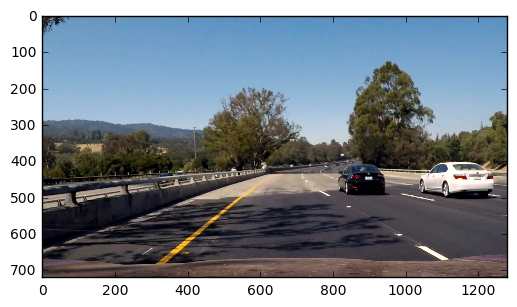

In [118]:
#reading in an image

#image = mpimg.imread('test_images/solidYellowCurve.jpg')
image = VideoFileClip('challenge.mp4').get_frame(3.84)

#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

(100, 700, 3)


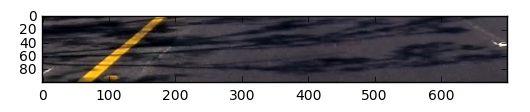

In [119]:
#test cell to remove
#plt.imshow(image)
x_center = image.shape[1]/2

crop_y_t = 560
crop_y_l = 660
crop_x_r = x_center+350
crop_x_l = x_center-350

#crop_y_t = 560
#crop_y_l = 660
#crop_x_r = x_center+500
#crop_x_l = x_center-500


crop_img = image[crop_y_t:crop_y_l,crop_x_l:crop_x_r]
plt.imshow(crop_img)
print(crop_img.shape)

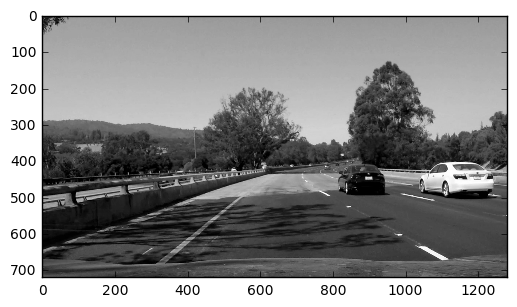

In [120]:
#reduce colored image to grayscaled image
image_grayed = grayscale(image)
plt.imshow(image_grayed, cmap='gray')

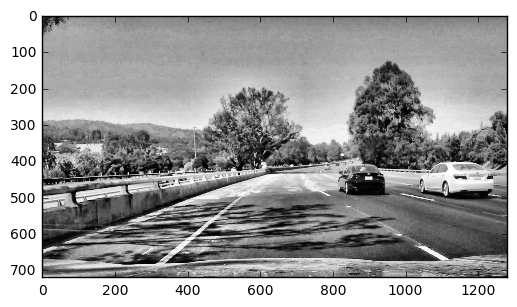

In [121]:
#apply CLAHE
image_clahe = CLAHE_img(image_grayed,4.0, (8,8))
plt.imshow(image_clahe, cmap='gray')

(223.18469999999999, 255)


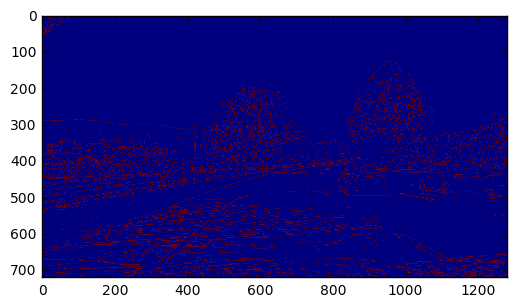

In [122]:
#apply canny to grayscaled image
canny_threshold = canny_auto_threshold(image_clahe)
image_canny = canny(image_clahe,canny_threshold[0],canny_threshold[1])
print(canny_threshold)
plt.imshow(image_canny)

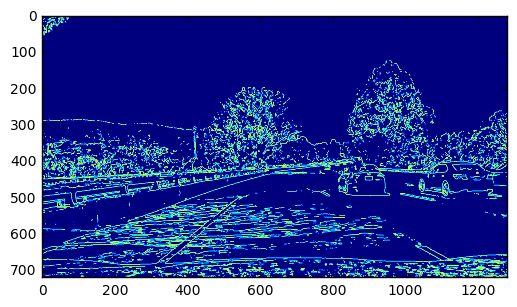

In [123]:
#apply gaussian blur to image
kernel_size = 3
image_gauss = gaussian_blur(image_canny,kernel_size)
plt.imshow(image_gauss)

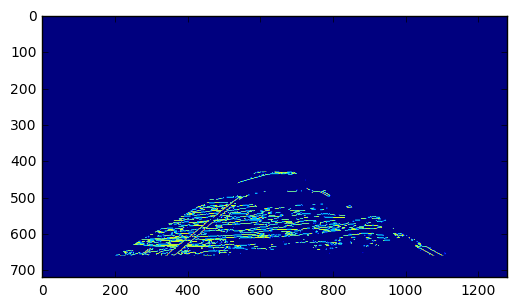

In [124]:
#pick area of interest
x_center = image.shape[1] / 2
top_left_v = (x_center-50,430)
low_left_v = (200,image.shape[0]-60)
top_right_v = (x_center+50,430)
low_right_v = (image.shape[1] - 150,image.shape[0]-60)
vertices = np.array([[top_left_v,low_left_v,low_right_v,top_right_v]],dtype=np.int32)
image_mask = region_of_interest(image_gauss,vertices)
plt.imshow(image_mask)

right lane slopes: [0.52173913043478259, 0.51351351351351349, 0.53846153846153844]
720 483 0.524571394137 769
left lane slopes: [-0.69230769230769229, -0.83720930232558144, -0.8125]
[(273, 720), (522, 526), (273, 720), (522, 526)]


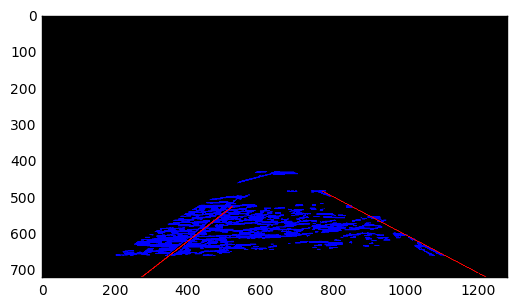

In [125]:
#determine hough lines
lines_hough = hough_lines(image_mask,0.8, np.pi/180, 30, 5, 5,right_left_lanes)
plt.imshow(lines_hough)

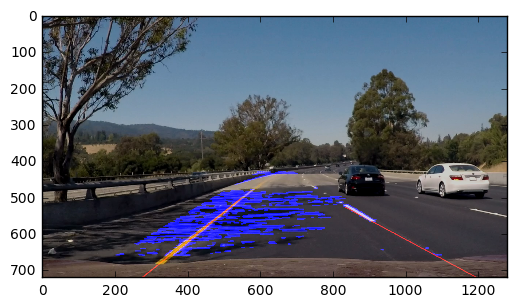

In [12]:
#Add weighed lines onto initial image
image_final = weighted_img(lines_hough,image)
plt.imshow(image_final)

In [60]:
def process_image(image):
    
    image_grayed = grayscale(image)
    image_clahe = CLAHE_img(image_grayed,4.0, (8,8))
    canny_threshold = canny_auto_threshold(image_clahe)
    image_canny = canny(image_clahe,canny_threshold[0],canny_threshold[1])
    kernel_size = 3
    image_gauss = gaussian_blur(image_canny,kernel_size)
    x_center = image.shape[1] / 2
    top_left_v = (x_center-50,430)
    low_left_v = (200,image.shape[0]-60)
    top_right_v = (x_center+50,430)
    low_right_v = (image.shape[1] - 150,image.shape[0]-60)
    vertices = np.array([[top_left_v,low_left_v,low_right_v,top_right_v]],dtype=np.int32)
    image_mask = region_of_interest(image_gauss,vertices)
    lines_hough = hough_lines(image_mask,0.8, np.pi/180, 30, 5, 5,right_left_lanes)
    image_final = weighted_img(lines_hough,image)
    plt.imshow(image_final)
        
    return image_final

right lane slopes: [0.59999999999999998, 0.62406015037593987, 0.59999999999999998, 0.57333333333333336, 0.5714285714285714, 0.80000000000000004, 0.62595419847328249, 0.57627118644067798, 0.64000000000000001, 0.62015503875968991, 0.5892857142857143, 0.64516129032258063, 0.7142857142857143, 0.67741935483870963, 0.63636363636363635, 0.54054054054054057, 0.59999999999999998, 0.5714285714285714, 0.62244897959183676, 0.69230769230769229, 0.55555555555555558, 0.5957446808510638, 0.57692307692307687, 0.61904761904761907, 0.68181818181818177, 0.66666666666666663, 0.55555555555555558, 0.5725190839694656, 0.59999999999999998, 0.75, 0.65000000000000002, 0.55000000000000004, 0.70588235294117652, 0.75, 0.5714285714285714, 0.54545454545454541, 0.66666666666666663, 0.6470588235294118, 0.59999999999999998, 0.54166666666666663]
720 444 0.623060800496 712
left lane slopes: [-0.67078189300411528, -0.67248908296943233, -0.67259786476868333, -0.69999999999999996, -0.75757575757575757, -0.70297029702970293, 

  0%|          | 0/251 [00:00<?, ?it/s]

right lane slopes: [0.59999999999999998, 0.62406015037593987, 0.59999999999999998, 0.57333333333333336, 0.5714285714285714, 0.80000000000000004, 0.62595419847328249, 0.57627118644067798, 0.64000000000000001, 0.62015503875968991, 0.5892857142857143, 0.64516129032258063, 0.7142857142857143, 0.67741935483870963, 0.63636363636363635, 0.54054054054054057, 0.59999999999999998, 0.5714285714285714, 0.62244897959183676, 0.69230769230769229, 0.55555555555555558, 0.5957446808510638, 0.57692307692307687, 0.61904761904761907, 0.68181818181818177, 0.66666666666666663, 0.55555555555555558, 0.5725190839694656, 0.59999999999999998, 0.75, 0.65000000000000002, 0.55000000000000004, 0.70588235294117652, 0.75, 0.5714285714285714, 0.54545454545454541, 0.66666666666666663, 0.6470588235294118, 0.59999999999999998, 0.54166666666666663]
720 444 0.623060800496 712
left lane slopes: [-0.67078189300411528, -0.67248908296943233, -0.67259786476868333, -0.69999999999999996, -0.75757575757575757, -0.70297029702970293, 

  0%|          | 1/251 [00:00<00:27,  8.99it/s]

right lane slopes: [0.59493670886075944, 0.6470588235294118, 0.59999999999999998, 0.5714285714285714, 0.62637362637362637, 0.6179775280898876, 0.63636363636363635, 0.62637362637362637, 0.66666666666666663, 0.61764705882352944, 0.61290322580645162, 0.66666666666666663, 0.58620689655172409, 0.65217391304347827, 0.60759493670886078, 0.53191489361702127, 0.5714285714285714, 0.58333333333333337, 0.66666666666666663, 0.58823529411764708, 0.62352941176470589, 0.6428571428571429, 0.59999999999999998, 0.53333333333333333, 0.5714285714285714, 0.60869565217391308, 0.65217391304347827, 0.55555555555555558, 0.57425742574257421, 0.625, 0.66666666666666663, 0.66666666666666663, 0.59999999999999998, 0.66666666666666663, 0.5714285714285714, 0.53125, 0.61538461538461542, 0.55555555555555558, 0.69999999999999996, 0.59999999999999998, 0.62068965517241381, 0.54545454545454541]
720 442 0.609489156984 712
left lane slopes: [-0.65094339622641506, -0.72972972972972971, -0.71999999999999997, -0.6744186046511627

  1%|          | 3/251 [00:00<00:31,  7.92it/s]

right lane slopes: [0.64516129032258063, 0.625, 0.58823529411764708, 0.70833333333333337, 0.68000000000000005, 0.61764705882352944, 0.63636363636363635, 0.59999999999999998, 0.65217391304347827, 0.75609756097560976, 0.65217391304347827, 0.6470588235294118, 0.75, 0.54545454545454541, 0.65517241379310343, 0.60606060606060608, 0.55555555555555558, 0.52000000000000002, 0.6428571428571429, 0.56666666666666665, 0.63636363636363635, 0.57894736842105265, 0.59999999999999998, 0.55555555555555558, 0.53125, 0.625, 0.5714285714285714, 0.55555555555555558, 0.625, 0.61290322580645162, 0.59999999999999998, 0.59999999999999998, 0.72727272727272729, 0.54545454545454541, 0.6428571428571429, 0.625, 0.54545454545454541, 0.61111111111111116, 0.58823529411764708, 0.5625, 0.59999999999999998, 0.63157894736842102, 0.58823529411764708, 0.59999999999999998, 0.5714285714285714, 0.59999999999999998, 0.75, 0.66666666666666663, 0.5714285714285714, 0.59999999999999998, 0.59090909090909094, 0.5714285714285714, 0.625,

  2%|▏         | 4/251 [00:00<00:32,  7.63it/s]

right lane slopes: [0.66666666666666663, 0.65306122448979587, 0.63636363636363635, 0.64000000000000001, 0.6470588235294118, 0.66666666666666663, 0.625, 0.69999999999999996, 0.7142857142857143, 0.63888888888888884, 0.72549019607843135, 0.67741935483870963, 0.6428571428571429, 0.61764705882352944, 0.66666666666666663, 0.67647058823529416, 0.61538461538461542, 0.66666666666666663, 0.52631578947368418, 0.66666666666666663, 0.5625, 0.70588235294117652, 0.66666666666666663, 0.72222222222222221, 0.54838709677419351, 0.66666666666666663, 0.59999999999999998, 0.69999999999999996, 0.57894736842105265, 0.68181818181818177, 0.57894736842105265, 0.5625, 0.5714285714285714, 0.55555555555555558, 0.52941176470588236, 0.68181818181818177, 0.7142857142857143, 0.6428571428571429, 0.6875, 0.75, 0.625, 0.59999999999999998, 0.66666666666666663, 0.6428571428571429, 0.59999999999999998, 0.62962962962962965, 0.65000000000000002]
720 445 0.642364354475 713
left lane slopes: [-0.65116279069767447, -0.66666666666

  2%|▏         | 5/251 [00:00<00:31,  7.90it/s]

right lane slopes: [0.65517241379310343, 0.66666666666666663, 0.59523809523809523, 0.65000000000000002, 0.63157894736842102, 0.75, 0.60526315789473684, 0.65517241379310343, 0.69230769230769229, 0.6470588235294118, 0.62962962962962965, 0.6097560975609756, 0.66666666666666663, 0.66666666666666663, 0.59999999999999998, 0.59999999999999998, 0.58823529411764708, 0.63636363636363635, 0.625, 0.59090909090909094, 0.66666666666666663, 0.63636363636363635, 0.7142857142857143, 0.66666666666666663, 0.625, 0.68421052631578949, 0.54545454545454541, 0.625, 0.59999999999999998, 0.62962962962962965, 0.66666666666666663, 0.5714285714285714, 0.625, 0.5714285714285714]
720 443 0.634984896689 713
left lane slopes: [-0.7142857142857143, -0.72549019607843135, -0.71186440677966101, -0.73333333333333328, -0.6964285714285714, -0.75, -0.73469387755102045, -0.75, -0.7078651685393258, -0.70370370370370372, -0.72727272727272729, -0.70588235294117652, -0.69999999999999996, -0.66666666666666663, -0.62068965517241381,

  2%|▏         | 6/251 [00:00<00:29,  8.25it/s]

right lane slopes: [0.7142857142857143, 0.64000000000000001, 0.625, 0.66666666666666663, 0.67441860465116277, 0.56000000000000005, 0.58695652173913049, 0.75, 0.66666666666666663, 0.75, 0.61538461538461542, 0.66666666666666663, 0.63636363636363635, 0.75, 0.66666666666666663, 0.66666666666666663, 0.63265306122448983, 0.66666666666666663, 0.7142857142857143, 0.66666666666666663, 0.66666666666666663, 0.63636363636363635, 0.60869565217391308, 0.56666666666666665, 0.60869565217391308, 0.66666666666666663, 0.64000000000000001, 0.59090909090909094, 0.5714285714285714, 0.59999999999999998, 0.65625, 0.75, 0.53333333333333333, 0.68965517241379315, 0.59999999999999998, 0.70588235294117652, 0.59999999999999998, 0.59999999999999998, 0.68292682926829273, 0.55555555555555558, 0.59999999999999998, 0.61904761904761907, 0.7142857142857143, 0.6875, 0.61904761904761907, 0.66666666666666663]
720 443 0.646788217396 713
left lane slopes: [-0.6495726495726496, -0.69886363636363635, -0.70666666666666667, -0.723

  3%|▎         | 7/251 [00:00<00:29,  8.39it/s]

right lane slopes: [0.63636363636363635, 0.61403508771929827, 0.7142857142857143, 0.62222222222222223, 0.61111111111111116, 0.64150943396226412, 0.625, 0.6470588235294118, 0.64516129032258063, 0.69999999999999996, 0.5714285714285714, 0.53846153846153844, 0.60344827586206895, 0.61111111111111116, 0.56521739130434778, 0.5714285714285714, 0.625, 0.5714285714285714, 0.5714285714285714, 0.6428571428571429, 0.56000000000000005, 0.625, 0.59459459459459463, 0.55555555555555558, 0.66666666666666663, 0.625, 0.64102564102564108, 0.6428571428571429, 0.6470588235294118, 0.66666666666666663, 0.625, 0.5714285714285714, 0.59999999999999998, 0.63636363636363635, 0.55000000000000004, 0.59999999999999998, 0.5714285714285714, 0.65625, 0.58823529411764708, 0.59999999999999998, 0.80000000000000004, 0.55769230769230771, 0.63636363636363635, 0.6470588235294118, 0.6428571428571429, 0.66666666666666663, 0.53846153846153844, 0.59999999999999998, 0.59999999999999998, 0.625, 0.58823529411764708]
720 443 0.61674556

  3%|▎         | 8/251 [00:00<00:28,  8.65it/s]

right lane slopes: [0.63636363636363635, 0.59999999999999998, 0.66666666666666663, 0.7142857142857143, 0.625, 0.69354838709677424, 0.6470588235294118, 0.6470588235294118, 0.68571428571428572, 0.69999999999999996, 0.65000000000000002, 0.63636363636363635, 0.67142857142857137, 0.6470588235294118, 0.65217391304347827, 0.625, 0.63888888888888884, 0.67647058823529416, 0.59999999999999998, 0.75, 0.7142857142857143, 0.63636363636363635, 0.66666666666666663, 0.65384615384615385, 0.75, 0.52941176470588236, 0.61111111111111116, 0.59999999999999998, 0.59999999999999998, 0.66666666666666663, 0.6428571428571429, 0.65151515151515149, 0.61904761904761907, 0.57894736842105265, 0.53333333333333333, 0.6428571428571429, 0.5714285714285714, 0.61111111111111116, 0.66666666666666663, 0.59999999999999998, 0.59999999999999998, 0.66666666666666663, 0.55555555555555558, 0.5714285714285714, 0.58333333333333337, 0.58823529411764708, 0.66666666666666663, 0.58333333333333337, 0.59999999999999998, 0.6666666666666666

  4%|▍         | 10/251 [00:01<00:26,  9.13it/s]

right lane slopes: [0.57342657342657344, 0.66666666666666663, 0.66666666666666663, 0.63636363636363635, 0.62686567164179108, 0.57446808510638303, 0.56666666666666665, 0.625, 0.59999999999999998, 0.66666666666666663, 0.57647058823529407, 0.66666666666666663, 0.62773722627737227, 0.5714285714285714, 0.61538461538461542, 0.62406015037593987, 0.55555555555555558, 0.57407407407407407, 0.59999999999999998, 0.65000000000000002, 0.53846153846153844, 0.55555555555555558, 0.625, 0.58181818181818179, 0.61904761904761907, 0.66666666666666663, 0.61111111111111116, 0.59999999999999998, 0.58823529411764708, 0.63636363636363635, 0.58823529411764708, 0.5714285714285714, 0.59999999999999998, 0.66666666666666663, 0.63636363636363635, 0.55555555555555558, 0.66666666666666663, 0.76923076923076927, 0.59999999999999998, 0.54545454545454541, 0.63157894736842102, 0.59999999999999998, 0.66666666666666663, 0.625, 0.55555555555555558, 0.58333333333333337, 0.66666666666666663, 0.625, 0.5714285714285714, 0.66666666

  5%|▍         | 12/251 [00:01<00:27,  8.80it/s]

right lane slopes: [0.57386363636363635, 0.64827586206896548, 0.65034965034965031, 0.58064516129032262, 0.66666666666666663, 0.64485981308411211, 0.61538461538461542, 0.66666666666666663, 0.56756756756756754, 0.65555555555555556, 0.59649122807017541, 0.65217391304347827, 0.68000000000000005, 0.65217391304347827, 0.63829787234042556, 0.57894736842105265, 0.64583333333333337, 0.66666666666666663, 0.58024691358024694, 0.7857142857142857, 0.59999999999999998, 0.76190476190476186, 0.75, 0.73684210526315785, 0.6875, 0.58823529411764708, 0.6071428571428571, 0.63157894736842102, 0.55555555555555558, 0.5714285714285714, 0.59999999999999998, 0.66666666666666663, 0.57894736842105265, 0.5714285714285714, 0.625, 0.66666666666666663, 0.61538461538461542, 0.68421052631578949, 0.52941176470588236, 0.59999999999999998, 0.61538461538461542, 0.66666666666666663, 0.63636363636363635, 0.57894736842105265, 0.55555555555555558, 0.58064516129032262, 0.59999999999999998, 0.66666666666666663, 0.5882352941176470

  5%|▌         | 13/251 [00:01<00:27,  8.80it/s]

right lane slopes: [0.58064516129032262, 0.5714285714285714, 0.64000000000000001, 0.54545454545454541, 0.59701492537313428, 0.62601626016260159, 0.64556962025316456, 0.61403508771929827, 0.58181818181818179, 0.62068965517241381, 0.63636363636363635, 0.61111111111111116, 0.65384615384615385, 0.64102564102564108, 0.68181818181818177, 0.55555555555555558, 0.68000000000000005, 0.58333333333333337, 0.68000000000000005, 0.71999999999999997, 0.5625, 0.59340659340659341, 0.640625, 0.660377358490566, 0.59999999999999998, 0.58333333333333337, 0.54545454545454541, 0.66666666666666663, 0.6428571428571429, 0.63636363636363635, 0.66666666666666663, 0.59999999999999998, 0.7142857142857143, 0.54545454545454541, 0.65217391304347827, 0.66666666666666663, 0.59999999999999998, 0.6097560975609756, 0.66666666666666663, 0.6428571428571429, 0.61538461538461542, 0.59999999999999998, 0.66666666666666663, 0.66666666666666663, 0.66666666666666663, 0.59375, 0.65384615384615385, 0.59999999999999998, 0.6363636363636

  6%|▌         | 15/251 [00:01<00:29,  8.09it/s]

right lane slopes: [0.65217391304347827, 0.7142857142857143, 0.68965517241379315, 0.66666666666666663, 0.60869565217391308, 0.68000000000000005, 0.53846153846153844, 0.58620689655172409, 0.66666666666666663, 0.58064516129032262, 0.6470588235294118, 0.53125, 0.69999999999999996, 0.59459459459459463, 0.60869565217391308, 0.59999999999999998, 0.66666666666666663, 0.66666666666666663, 0.7142857142857143, 0.66666666666666663, 0.72727272727272729, 0.66666666666666663, 0.57894736842105265, 0.64000000000000001, 0.55555555555555558, 0.5714285714285714, 0.68000000000000005, 0.6428571428571429, 0.5625, 0.58333333333333337, 0.64000000000000001, 0.63888888888888884, 0.59999999999999998, 0.59090909090909094, 0.51851851851851849, 0.5357142857142857, 0.54545454545454541, 0.59999999999999998, 0.7142857142857143, 0.5625, 0.65625, 0.61111111111111116, 0.66666666666666663, 0.75, 0.54545454545454541, 0.66666666666666663, 0.65517241379310343, 0.59999999999999998, 0.55555555555555558, 0.59999999999999998, 0.

  8%|▊         | 19/251 [00:02<00:26,  8.79it/s]

right lane slopes: [0.66666666666666663, 0.65217391304347827, 0.62068965517241381, 0.59183673469387754, 0.625, 0.60869565217391308, 0.61538461538461542, 0.68571428571428572, 0.63157894736842102, 0.625, 0.59999999999999998, 0.68571428571428572, 0.55555555555555558, 0.55555555555555558, 0.66666666666666663, 0.625, 0.625, 0.6470588235294118, 0.69999999999999996, 0.57894736842105265, 0.63636363636363635, 0.54545454545454541, 0.7142857142857143, 0.70588235294117652, 0.66666666666666663, 0.65384615384615385, 0.70833333333333337, 0.59999999999999998, 0.6470588235294118, 0.625, 0.55555555555555558, 0.5714285714285714, 0.65384615384615385, 0.63157894736842102, 0.62962962962962965, 0.68181818181818177, 0.66666666666666663, 0.67741935483870963, 0.52631578947368418, 0.53846153846153844, 0.59999999999999998, 0.7142857142857143, 0.63636363636363635, 0.7142857142857143]
720 443 0.633245122866 714
left lane slopes: [-0.69886363636363635, -0.75, -0.75, -0.78947368421052633, -0.70967741935483875, -0.701

  9%|▉         | 22/251 [00:02<00:26,  8.78it/s]

right lane slopes: [0.66666666666666663, 0.58823529411764708, 0.57446808510638303, 0.66666666666666663, 0.64406779661016944, 0.59999999999999998, 0.67088607594936711, 0.66666666666666663, 0.66666666666666663, 0.57446808510638303, 0.58441558441558439, 0.80000000000000004, 0.82352941176470584, 0.65333333333333332, 0.75, 0.75, 0.83333333333333337, 0.66666666666666663, 0.64000000000000001, 0.7857142857142857, 0.61538461538461542, 0.58333333333333337, 0.6470588235294118, 0.8125, 0.83333333333333337, 0.54545454545454541, 0.7142857142857143]
720 444 0.6798938883 714
left lane slopes: [-0.72440944881889768, -0.72614107883817425, -0.7225433526011561, -0.75531914893617025, -0.75, -0.76190476190476186, -0.71962616822429903, -0.75, -0.75862068965517238, -0.75, -0.72727272727272729, -0.72093023255813948, -0.66666666666666663, -0.76923076923076927, -0.69230769230769229, -0.80000000000000004, -0.66666666666666663, -0.7142857142857143, -0.7142857142857143, -0.75757575757575757, -0.73076923076923073, -

  9%|▉         | 23/251 [00:02<00:26,  8.52it/s]

right lane slopes: [0.65441176470588236, 0.59848484848484851, 0.59259259259259256, 0.64516129032258063, 0.63934426229508201, 0.59649122807017541, 0.625, 0.647887323943662, 0.68181818181818177, 0.6470588235294118, 0.59999999999999998, 0.625, 0.625, 0.625, 0.59999999999999998, 0.8125, 0.59999999999999998, 0.59999999999999998, 0.66666666666666663, 0.59999999999999998, 0.62222222222222223, 0.65517241379310343, 0.66666666666666663, 0.69999999999999996, 0.55555555555555558, 0.80000000000000004, 0.60139860139860135, 0.77777777777777779, 0.66666666666666663, 0.66666666666666663, 0.80000000000000004, 0.66666666666666663, 0.59999999999999998, 0.55555555555555558, 0.66000000000000003, 0.59999999999999998, 0.7142857142857143, 0.81818181818181823, 0.5968992248062015, 0.625, 0.7857142857142857, 0.5714285714285714]
720 444 0.652101794996 717
left lane slopes: [-0.72413793103448276, -0.72185430463576161, -0.75, -0.72340425531914898, -0.77777777777777779, -0.75362318840579712, -0.72448979591836737, -0.

 10%|█         | 26/251 [00:03<00:26,  8.46it/s]

right lane slopes: [0.55208333333333337, 0.55789473684210522, 0.65333333333333332, 0.625, 0.6470588235294118, 0.63265306122448983, 0.65517241379310343, 0.66666666666666663, 0.55769230769230771, 0.65625, 0.62068965517241381, 0.63636363636363635, 0.6470588235294118, 0.59999999999999998, 0.64516129032258063, 0.66666666666666663, 0.6428571428571429, 0.61538461538461542, 0.52941176470588236, 0.59999999999999998, 0.65384615384615385, 0.6333333333333333, 0.6470588235294118, 0.59999999999999998, 0.69230769230769229, 0.63636363636363635, 0.65957446808510634, 0.625, 0.66666666666666663, 0.6428571428571429]
720 446 0.628813539614 716
left lane slopes: [-0.69784172661870503, -0.72677595628415304, -0.70149253731343286, -0.69999999999999996, -0.69999999999999996, -0.7289719626168224, -0.72857142857142854, -0.69999999999999996, -0.75, -0.67741935483870963, -0.66666666666666663, -0.73333333333333328, -0.72992700729927007, -0.67741935483870963, -0.83333333333333337, -0.75, -0.75, -0.75, -0.724137931034

 12%|█▏        | 29/251 [00:03<00:25,  8.55it/s]

right lane slopes: [0.63636363636363635, 0.66666666666666663, 0.5714285714285714, 0.7142857142857143, 0.6470588235294118, 0.69999999999999996, 0.66666666666666663, 0.61538461538461542, 0.61538461538461542, 0.63636363636363635, 0.66666666666666663, 0.66666666666666663, 0.63636363636363635, 0.63636363636363635, 0.625, 0.59999999999999998, 0.66666666666666663, 0.59999999999999998, 0.75, 0.66666666666666663, 0.61538461538461542, 0.66666666666666663, 0.69999999999999996, 0.66666666666666663, 0.66666666666666663, 0.69999999999999996, 0.66666666666666663, 0.64102564102564108, 0.625, 0.66666666666666663, 0.66666666666666663, 0.66666666666666663, 0.66666666666666663, 0.66666666666666663, 0.54545454545454541, 0.69999999999999996, 0.63157894736842102, 0.7142857142857143, 0.80000000000000004, 0.59999999999999998, 0.68000000000000005]
720 444 0.656993325585 715
left lane slopes: [-0.74626865671641796, -0.69784172661870503, -0.77830188679245282, -0.69999999999999996, -0.69999999999999996, -0.7792207

 12%|█▏        | 31/251 [00:03<00:25,  8.75it/s]

right lane slopes: [0.65000000000000002, 0.59999999999999998, 0.68627450980392157, 0.65306122448979587, 0.67307692307692313, 0.61904761904761907, 0.75, 0.61904761904761907, 0.57894736842105265, 0.63157894736842102, 0.63829787234042556, 0.63636363636363635, 0.70833333333333337, 0.66666666666666663, 0.66666666666666663, 0.63157894736842102, 0.66666666666666663, 0.83333333333333337, 0.64516129032258063, 0.61290322580645162, 0.7142857142857143, 0.63636363636363635, 0.59999999999999998, 0.66666666666666663, 0.61538461538461542, 0.68000000000000005, 0.63636363636363635, 0.58333333333333337, 0.65625, 0.66666666666666663, 0.66666666666666663, 0.59999999999999998, 0.66666666666666663, 0.5714285714285714, 0.6470588235294118, 0.5714285714285714, 0.70588235294117652, 0.63636363636363635, 0.6470588235294118, 0.65625, 0.58823529411764708, 0.61538461538461542, 0.63157894736842102]
720 443 0.647123792758 715
left lane slopes: [-0.75221238938053092, -0.69999999999999996, -0.75641025641025639, -0.699999

 13%|█▎        | 33/251 [00:03<00:24,  8.84it/s]

right lane slopes: [0.70149253731343286, 0.64864864864864868, 0.6785714285714286, 0.61643835616438358, 0.58620689655172409, 0.60526315789473684, 0.65000000000000002, 0.60563380281690138, 0.63636363636363635, 0.66666666666666663, 0.68181818181818177, 0.69230769230769229, 0.55555555555555558, 0.5714285714285714, 0.61538461538461542, 0.65714285714285714, 0.71698113207547165, 0.625, 0.6470588235294118, 0.69230769230769229, 0.59999999999999998, 0.62264150943396224, 0.7142857142857143, 0.61111111111111116, 0.6428571428571429, 0.75, 0.61538461538461542, 0.59999999999999998, 0.6875, 0.63636363636363635, 0.66666666666666663, 0.76000000000000001, 0.53846153846153844, 0.65217391304347827, 0.72222222222222221, 0.7142857142857143, 0.83333333333333337, 0.58333333333333337, 0.63265306122448983, 0.69230769230769229, 0.64516129032258063, 0.66666666666666663, 0.63636363636363635, 0.78947368421052633, 0.75, 0.7142857142857143, 0.75, 0.80000000000000004]
720 431 0.664120884348 691
left lane slopes: [-0.70

 14%|█▎        | 34/251 [00:03<00:24,  8.87it/s]

right lane slopes: [0.64516129032258063, 0.64423076923076927, 0.66666666666666663, 0.62616822429906538, 0.64444444444444449, 0.625, 0.66666666666666663, 0.65517241379310343, 0.6470588235294118, 0.6428571428571429, 0.69090909090909092, 0.65517241379310343, 0.55555555555555558, 0.66666666666666663, 0.70833333333333337, 0.64761904761904765, 0.57894736842105265, 0.65000000000000002, 0.61904761904761907, 0.64516129032258063, 0.64516129032258063, 0.59999999999999998, 0.63636363636363635, 0.60869565217391308, 0.63636363636363635, 0.69230769230769229, 0.6428571428571429, 0.68181818181818177, 0.66666666666666663, 0.65625, 0.73684210526315785, 0.63157894736842102, 0.62857142857142856, 0.660377358490566, 0.63636363636363635, 0.60606060606060608, 0.55555555555555558, 0.6428571428571429, 0.59999999999999998, 0.59999999999999998, 0.63157894736842102, 0.66666666666666663, 0.66666666666666663, 0.59999999999999998, 0.66666666666666663]
720 447 0.641713521206 715
left lane slopes: [-0.69918699186991873,

 14%|█▍        | 36/251 [00:04<00:23,  9.22it/s]

right lane slopes: [0.57317073170731703, 0.64761904761904765, 0.64615384615384619, 0.58024691358024694, 0.58823529411764708, 0.64130434782608692, 0.58823529411764708, 0.6470588235294118, 0.56818181818181823, 0.6428571428571429, 0.59999999999999998, 0.70833333333333337, 0.59999999999999998, 0.72727272727272729, 0.64000000000000001, 0.61538461538461542, 0.77777777777777779, 0.66666666666666663, 0.58823529411764708, 0.5714285714285714, 0.68421052631578949, 0.58536585365853655, 0.65217391304347827, 0.59999999999999998, 0.59999999999999998, 0.59999999999999998, 0.66666666666666663, 0.72222222222222221, 0.59259259259259256, 0.76923076923076927, 0.65909090909090906, 0.57961783439490444, 0.66666666666666663, 0.59999999999999998, 0.7142857142857143, 0.66666666666666663, 0.6428571428571429, 0.61538461538461542, 0.63636363636363635, 0.54166666666666663, 0.5625, 0.5714285714285714]
720 446 0.632075076505 713
left lane slopes: [-0.69892473118279574, -0.65142857142857147, -0.77777777777777779, -0.70

 16%|█▌        | 40/251 [00:04<00:21,  9.74it/s]

right lane slopes: [0.66666666666666663, 0.625, 0.70833333333333337, 0.59999999999999998, 0.65217391304347827, 0.59999999999999998, 0.625, 0.62222222222222223, 0.65517241379310343, 0.6428571428571429, 0.59999999999999998, 0.55555555555555558, 0.66666666666666663, 0.64000000000000001, 0.58333333333333337, 0.59999999999999998, 0.61538461538461542, 0.59999999999999998, 0.59999999999999998, 0.59999999999999998, 0.61111111111111116, 0.61538461538461542, 0.67741935483870963, 0.62222222222222223, 0.66666666666666663, 0.66666666666666663, 0.66666666666666663, 0.59999999999999998, 0.52380952380952384, 0.58333333333333337, 0.625, 0.61538461538461542, 0.59999999999999998, 0.59999999999999998, 0.61290322580645162, 0.59999999999999998, 0.625, 0.66666666666666663, 0.63636363636363635, 0.66666666666666663, 0.56521739130434778, 0.625, 0.625, 0.59999999999999998, 0.59999999999999998, 0.63636363636363635, 0.66666666666666663, 0.75, 0.7142857142857143, 0.66666666666666663, 0.59999999999999998, 0.66666666

 17%|█▋        | 42/251 [00:04<00:23,  8.89it/s]

right lane slopes: [0.65000000000000002, 0.61904761904761907, 0.5714285714285714, 0.61363636363636365, 0.61538461538461542, 0.65853658536585369, 0.66666666666666663, 0.59999999999999998, 0.65116279069767447, 0.6071428571428571, 0.625, 0.66666666666666663, 0.5714285714285714, 0.75862068965517238, 0.6428571428571429, 0.6071428571428571, 0.62790697674418605, 0.63636363636363635, 0.59259259259259256, 0.61904761904761907, 0.66666666666666663, 0.66666666666666663, 0.5714285714285714, 0.69999999999999996, 0.73333333333333328, 0.63636363636363635, 0.6428571428571429, 0.69230769230769229, 0.625, 0.6071428571428571, 0.59999999999999998, 0.66666666666666663, 0.66666666666666663, 0.70588235294117652, 0.69999999999999996, 0.7857142857142857, 0.62068965517241381, 0.5714285714285714, 0.5714285714285714, 0.67647058823529416, 0.63636363636363635, 0.75, 0.69999999999999996, 0.65000000000000002, 0.83333333333333337, 0.59999999999999998, 0.63636363636363635, 0.69999999999999996, 0.625]
720 444 0.649763415

 18%|█▊        | 44/251 [00:05<00:28,  7.36it/s]

right lane slopes: [0.63888888888888884, 0.62121212121212122, 0.62121212121212122, 0.625, 0.5757575757575758, 0.57894736842105265, 0.66666666666666663, 0.59999999999999998, 0.65625, 0.6071428571428571, 0.65625, 0.57971014492753625, 0.60869565217391308, 0.63157894736842102, 0.64150943396226412, 0.59999999999999998, 0.8571428571428571, 0.5714285714285714, 0.67647058823529416, 0.5714285714285714, 0.625, 0.80645161290322576, 0.58064516129032262, 0.65909090909090906, 0.55555555555555558, 0.6428571428571429, 0.7142857142857143, 0.8125]
720 444 0.642202802213 716
left lane slopes: [-0.72727272727272729, -0.72619047619047616, -0.70085470085470081, -0.68965517241379315, -0.68421052631578949, -0.71698113207547165, -0.64804469273743015, -0.7142857142857143, -0.74285714285714288, -0.72307692307692306, -0.671875, -0.7441860465116279, -0.75757575757575757, -0.75, -0.68000000000000005, -0.66666666666666663, -0.69230769230769229, -0.79487179487179482, -0.69565217391304346, -0.75, -0.65517241379310343,

 18%|█▊        | 46/251 [00:05<00:26,  7.66it/s]

right lane slopes: [0.6333333333333333, 0.62765957446808507, 0.5544554455445545, 0.6428571428571429, 0.6875, 0.71052631578947367, 0.70588235294117652, 0.63888888888888884, 0.69230769230769229, 0.69230769230769229, 0.73333333333333328, 0.55555555555555558, 0.69230769230769229, 0.7142857142857143, 0.69565217391304346, 0.55737704918032782, 0.56000000000000005, 0.73913043478260865, 0.6875, 0.69444444444444442, 0.59999999999999998, 0.80000000000000004, 0.7142857142857143, 0.66666666666666663, 0.55555555555555558, 0.63157894736842102, 0.55555555555555558, 0.55555555555555558, 0.54545454545454541, 0.5714285714285714, 0.55263157894736847, 0.66666666666666663, 0.625, 0.63157894736842102, 0.63636363636363635]
720 446 0.643532193642 717
left lane slopes: [-0.72881355932203384, -0.80000000000000004, -0.74285714285714288, -0.76271186440677963, -0.76000000000000001, -0.64971751412429379, -0.79545454545454541, -0.7068965517241379, -0.7857142857142857, -0.75, -0.78260869565217395, -0.69230769230769229

 19%|█▊        | 47/251 [00:05<00:27,  7.44it/s]

right lane slopes: [0.62580645161290327, 0.59999999999999998, 0.55555555555555558, 0.5535714285714286, 0.61842105263157898, 0.6216216216216216, 0.54545454545454541, 0.55639097744360899, 0.65000000000000002, 0.75, 0.5714285714285714, 0.75510204081632648, 0.5625, 0.53968253968253965, 0.72727272727272729, 0.76923076923076927, 0.59999999999999998, 0.55844155844155841, 0.59999999999999998, 0.8125, 0.75, 0.63829787234042556, 0.69230769230769229, 0.6428571428571429, 0.6376811594202898, 0.55555555555555558, 0.51724137931034486, 0.5625, 0.75, 0.625, 0.61111111111111116, 0.56862745098039214, 0.63492063492063489]
720 446 0.629063025411 717
left lane slopes: [-0.67193675889328064, -0.67361111111111116, -0.72522522522522526, -0.75, -0.78378378378378377, -0.76470588235294112, -0.76470588235294112, -0.76923076923076927, -0.7142857142857143, -0.74358974358974361, -0.76923076923076927, -0.75, -0.73684210526315785, -0.72388059701492535, -0.77272727272727271, -0.83333333333333337, -0.8125, -0.71428571428

 20%|█▉        | 50/251 [00:05<00:28,  7.03it/s]

right lane slopes: [0.57657657657657657, 0.63636363636363635, 0.61538461538461542, 0.64583333333333337, 0.57017543859649122, 0.640625, 0.61971830985915488, 0.57281553398058249, 0.66666666666666663, 0.65384615384615385, 0.65384615384615385, 0.62962962962962965, 0.75, 0.5714285714285714, 0.61111111111111116, 0.5803571428571429, 0.66666666666666663, 0.7142857142857143, 0.58333333333333337, 0.64772727272727271, 0.68421052631578949, 0.63636363636363635, 0.66666666666666663, 0.75, 0.66666666666666663, 0.6428571428571429, 0.57692307692307687, 0.625, 0.6428571428571429, 0.68181818181818177, 0.63636363636363635, 0.66666666666666663, 0.5714285714285714, 0.64864864864864868, 0.65217391304347827, 0.5714285714285714, 0.66666666666666663, 0.66666666666666663]
720 445 0.638415716891 717
left lane slopes: [-0.76190476190476186, -0.67375886524822692, -0.77586206896551724, -0.69999999999999996, -0.69999999999999996, -0.77777777777777779, -0.69999999999999996, -0.66666666666666663, -0.78947368421052633, 

 20%|██        | 51/251 [00:06<00:28,  6.90it/s]

right lane slopes: [0.5714285714285714, 0.67647058823529416, 0.59999999999999998, 0.6428571428571429, 0.59999999999999998, 0.6428571428571429, 0.59999999999999998, 0.59999999999999998, 0.66666666666666663, 0.63157894736842102, 0.72727272727272729, 0.59999999999999998, 0.53846153846153844, 0.70588235294117652, 0.71875, 0.54545454545454541, 0.55555555555555558, 0.52941176470588236, 0.625, 0.66666666666666663, 0.58823529411764708, 0.57894736842105265, 0.5625, 0.59999999999999998, 0.625, 0.6428571428571429, 0.59999999999999998, 0.5714285714285714, 0.6428571428571429, 0.6428571428571429, 0.5625, 0.59999999999999998, 0.53333333333333333, 0.6875, 0.62068965517241381, 0.5714285714285714, 0.55555555555555558, 0.58333333333333337, 0.59999999999999998, 0.625, 0.66666666666666663, 0.61904761904761907, 0.61538461538461542, 0.5625, 0.8125, 0.59999999999999998, 0.77777777777777779, 0.59999999999999998, 0.58333333333333337, 0.61111111111111116, 0.69999999999999996, 0.75]
720 444 0.621858816253 717
lef

 21%|██        | 53/251 [00:06<00:29,  6.77it/s]

right lane slopes: [0.59999999999999998, 0.59999999999999998, 0.66666666666666663, 0.62962962962962965, 0.61363636363636365, 0.61538461538461542, 0.59090909090909094, 0.56521739130434778, 0.58139534883720934, 0.5957446808510638, 0.59999999999999998, 0.58333333333333337, 0.60869565217391308, 0.59999999999999998, 0.60869565217391308, 0.65384615384615385, 0.625, 0.59999999999999998, 0.63157894736842102, 0.75, 0.61538461538461542, 0.63636363636363635, 0.69230769230769229, 0.5714285714285714, 0.6470588235294118, 0.63157894736842102, 0.81818181818181823, 0.58333333333333337, 0.59090909090909094, 0.58333333333333337, 0.75, 0.59999999999999998, 0.63636363636363635, 0.59999999999999998, 0.5625, 0.61290322580645162, 0.59999999999999998, 0.5714285714285714]
720 444 0.621652863733 717
left lane slopes: [-0.70050761421319796, -0.69724770642201839, -0.69767441860465118, -0.70121951219512191, -0.72727272727272729, -0.69117647058823528, -0.81034482758620685, -0.69613259668508287, -0.78181818181818186,

 22%|██▏       | 56/251 [00:06<00:27,  7.19it/s]

right lane slopes: [0.6470588235294118, 0.61111111111111116, 0.5714285714285714, 0.609375, 0.61538461538461542, 0.6470588235294118, 0.61538461538461542, 0.61538461538461542, 0.67164179104477617, 0.62068965517241381, 0.59420289855072461, 0.58333333333333337, 0.66666666666666663, 0.72222222222222221, 0.55555555555555558, 0.61904761904761907, 0.59999999999999998, 0.5714285714285714, 0.66666666666666663, 0.61538461538461542, 0.5714285714285714, 0.59999999999999998, 0.61538461538461542, 0.72727272727272729, 0.55555555555555558, 0.68181818181818177, 0.65000000000000002, 0.66666666666666663, 0.63636363636363635, 0.59999999999999998, 0.625, 0.875, 0.58333333333333337, 0.55555555555555558, 0.82352941176470584, 0.59999999999999998, 0.70370370370370372, 0.6470588235294118, 0.625, 0.64516129032258063, 0.66666666666666663, 0.61904761904761907, 0.58823529411764708, 0.55555555555555558, 0.66666666666666663, 0.5714285714285714, 0.54545454545454541, 0.75, 0.69999999999999996, 0.625, 0.5714285714285714,

 23%|██▎       | 58/251 [00:06<00:26,  7.35it/s]

right lane slopes: [0.59302325581395354, 0.72222222222222221, 0.59999999999999998, 0.69999999999999996, 0.61111111111111116, 0.6470588235294118, 0.625, 0.62790697674418605, 0.63461538461538458, 0.6428571428571429, 0.61111111111111116, 0.53333333333333333, 0.75, 0.51162790697674421, 0.66666666666666663, 0.625, 0.61818181818181817, 0.76470588235294112, 0.59999999999999998, 0.54545454545454541, 0.5714285714285714, 0.54545454545454541, 0.55882352941176472, 0.66666666666666663, 0.61904761904761907, 0.64000000000000001, 0.61363636363636365, 0.7142857142857143, 0.57692307692307687, 0.59999999999999998, 0.56000000000000005, 0.66666666666666663, 0.67741935483870963, 0.63157894736842102, 0.6428571428571429, 0.66666666666666663, 0.59999999999999998, 0.59090909090909094, 0.5714285714285714, 0.55000000000000004, 0.70833333333333337, 0.55000000000000004, 0.5714285714285714, 0.5714285714285714, 0.5714285714285714, 0.58823529411764708, 0.62962962962962965, 0.62222222222222223, 0.625, 0.666666666666666

 24%|██▍       | 60/251 [00:07<00:26,  7.32it/s]

right lane slopes: [0.5572519083969466, 0.625, 0.62222222222222223, 0.59999999999999998, 0.57692307692307687, 0.54545454545454541, 0.61538461538461542, 0.60126582278481011, 0.61538461538461542, 0.59405940594059403, 0.59999999999999998, 0.58823529411764708, 0.65000000000000002, 0.7142857142857143, 0.68181818181818177, 0.63888888888888884, 0.66000000000000003, 0.68421052631578949, 0.54545454545454541, 0.80952380952380953, 0.72972972972972971, 0.73913043478260865, 0.58695652173913049, 0.80952380952380953, 0.75, 0.5641025641025641, 0.75, 0.65000000000000002, 0.63636363636363635, 0.58333333333333337, 0.55555555555555558, 0.59999999999999998, 0.55555555555555558, 0.63888888888888884, 0.65000000000000002, 0.66666666666666663, 0.59999999999999998, 0.58823529411764708, 0.59999999999999998, 0.59999999999999998, 0.64000000000000001, 0.58333333333333337, 0.58333333333333337]
720 440 0.632234228603 710
left lane slopes: [-0.69960474308300391, -0.75121951219512195, -0.75, -0.75, -0.83333333333333337

 25%|██▍       | 62/251 [00:07<00:23,  7.88it/s]

right lane slopes: [0.67901234567901236, 0.59405940594059403, 0.5714285714285714, 0.6179775280898876, 0.57894736842105265, 0.57894736842105265, 0.65000000000000002, 0.6428571428571429, 0.6785714285714286, 0.65822784810126578, 0.63636363636363635, 0.7142857142857143, 0.625, 0.65217391304347827, 0.6428571428571429, 0.58823529411764708, 0.5714285714285714, 0.5714285714285714, 0.70833333333333337, 0.65517241379310343, 0.66666666666666663, 0.7142857142857143, 0.625, 0.63636363636363635, 0.59999999999999998, 0.625, 0.7142857142857143, 0.625, 0.65384615384615385, 0.55555555555555558, 0.59999999999999998, 0.65000000000000002, 0.59999999999999998, 0.625, 0.63043478260869568, 0.58333333333333337, 0.59999999999999998, 0.66666666666666663, 0.59999999999999998]
720 441 0.630429380045 712
left lane slopes: [-0.69758064516129037, -0.69683257918552033, -0.80597014925373134, -0.80597014925373134, -0.72826086956521741, -0.72307692307692306, -0.73333333333333328, -0.78260869565217395, -0.7272727272727272

 25%|██▌       | 64/251 [00:07<00:24,  7.67it/s]

right lane slopes: [0.66666666666666663, 0.57894736842105265, 0.59999999999999998, 0.58333333333333337, 0.62857142857142856, 0.58333333333333337, 0.59999999999999998, 0.59999999999999998, 0.61290322580645162, 0.59375, 0.60526315789473684, 0.58974358974358976, 0.625, 0.57692307692307687, 0.5625, 0.625, 0.59259259259259256, 0.6333333333333333, 0.59999999999999998, 0.66666666666666663, 0.64516129032258063, 0.59999999999999998, 0.61538461538461542, 0.54545454545454541, 0.63636363636363635, 0.59999999999999998, 0.62857142857142856, 0.53846153846153844, 0.63636363636363635, 0.59999999999999998, 0.58333333333333337, 0.59999999999999998, 0.58333333333333337, 0.53846153846153844, 0.58333333333333337, 0.66666666666666663, 0.69999999999999996, 0.5714285714285714, 0.55555555555555558, 0.58333333333333337, 0.72727272727272729, 0.54545454545454541, 0.76923076923076927, 0.58333333333333337, 0.54545454545454541, 0.625, 0.59999999999999998, 0.58823529411764708, 0.63636363636363635]
720 442 0.6072669179

 26%|██▋       | 66/251 [00:08<00:22,  8.11it/s]

right lane slopes: [0.59999999999999998, 0.63414634146341464, 0.5714285714285714, 0.59999999999999998, 0.59999999999999998, 0.7142857142857143, 0.7021276595744681, 0.56521739130434778, 0.66666666666666663, 0.59459459459459463, 0.65853658536585369, 0.62068965517241381, 0.625, 0.69444444444444442, 0.625, 0.68518518518518523, 0.58333333333333337, 0.66666666666666663, 0.6071428571428571, 0.59999999999999998, 0.6428571428571429, 0.66666666666666663, 0.59999999999999998]
720 441 0.631477803311 711
left lane slopes: [-0.77586206896551724, -0.65000000000000002, -0.76190476190476186, -0.7142857142857143, -0.78125, -0.75555555555555554, -0.7816091954022989, -0.81818181818181823, -0.7857142857142857, -0.703125, -0.77419354838709675, -0.78125, -0.7142857142857143, -0.76923076923076927, -0.76923076923076927, -0.80000000000000004, -0.80000000000000004, -0.66666666666666663, -0.67741935483870963, -0.75, -0.65322580645161288, -0.75, -0.625, -0.75, -0.65420560747663548, -0.80000000000000004, -0.7391304

 27%|██▋       | 68/251 [00:08<00:22,  8.16it/s]

right lane slopes: [0.6071428571428571, 0.62, 0.58823529411764708, 0.58666666666666667, 0.61224489795918369, 0.65079365079365081, 0.640625, 0.625, 0.625, 0.625, 0.66666666666666663, 0.625, 0.61764705882352944, 0.62686567164179108, 0.58695652173913049, 0.59154929577464788, 0.61538461538461542, 0.59999999999999998, 0.61538461538461542, 0.58333333333333337, 0.61224489795918369, 0.63636363636363635, 0.66666666666666663, 0.58823529411764708, 0.66666666666666663, 0.59999999999999998]
720 443 0.618448973354 711
left lane slopes: [-0.67368421052631577, -0.67450980392156867, -0.78125, -0.69999999999999996, -0.70078740157480313, -0.77906976744186052, -0.75806451612903225, -0.72727272727272729, -0.75, -0.73170731707317072, -0.75, -0.72463768115942029, -0.75, -0.71999999999999997, -0.74285714285714288, -0.7142857142857143, -0.7857142857142857, -0.67158671586715868, -0.69999999999999996, -0.66666666666666663, -0.80000000000000004, -0.66666666666666663, -0.75409836065573765, -0.68181818181818177, -0

 28%|██▊       | 70/251 [00:08<00:22,  8.04it/s]

right lane slopes: [0.62264150943396224, 0.60377358490566035, 0.59999999999999998, 0.625, 0.5752212389380531, 0.62376237623762376, 0.57657657657657657, 0.62745098039215685, 0.57692307692307687, 0.58333333333333337, 0.59999999999999998, 0.58024691358024694, 0.60869565217391308, 0.68181818181818177, 0.6470588235294118, 0.55555555555555558, 0.66666666666666663, 0.59999999999999998, 0.6428571428571429, 0.62962962962962965, 0.58441558441558439, 0.58064516129032262, 0.59999999999999998, 0.59999999999999998]
720 445 0.608011332844 713
left lane slopes: [-0.6738351254480287, -0.67368421052631577, -0.72457627118644063, -0.72522522522522526, -0.67475728155339809, -0.67701863354037262, -0.76000000000000001, -0.72727272727272729, -0.69999999999999996, -0.73913043478260865, -0.83333333333333337, -0.69999999999999996, -0.80000000000000004, -0.67142857142857137, -0.75, -0.66666666666666663, -0.75, -0.66666666666666663, -0.75, -0.63636363636363635, -0.83333333333333337, -0.72727272727272729, -0.800000

 29%|██▊       | 72/251 [00:08<00:22,  8.08it/s]

right lane slopes: [0.61935483870967745, 0.57471264367816088, 0.57309941520467833, 0.62037037037037035, 0.57309941520467833, 0.61904761904761907, 0.62068965517241381, 0.75, 0.65789473684210531, 0.63636363636363635, 0.65384615384615385, 0.66666666666666663, 0.66666666666666663, 0.66000000000000003, 0.68000000000000005, 0.56521739130434778, 0.625, 0.5780346820809249, 0.72727272727272729, 0.66666666666666663, 0.72727272727272729, 0.68000000000000005, 0.66666666666666663, 0.58333333333333337, 0.6470588235294118, 0.63265306122448983, 0.57894736842105265, 0.80000000000000004, 0.73333333333333328, 0.66666666666666663, 0.69565217391304346, 0.7142857142857143, 0.62068965517241381]
720 446 0.650926145725 713
left lane slopes: [-0.69758064516129037, -0.69758064516129037, -0.69886363636363635, -0.72789115646258506, -0.70588235294117652, -0.69868995633187769, -0.69999999999999996, -0.72727272727272729, -0.73333333333333328, -0.72463768115942029, -0.7142857142857143, -0.75, -0.69999999999999996, -0.

 29%|██▉       | 74/251 [00:08<00:21,  8.15it/s]

right lane slopes: [0.53846153846153844, 0.58064516129032262, 0.5679012345679012, 0.5679012345679012, 0.60526315789473684, 0.625, 0.59999999999999998, 0.57894736842105265, 0.58064516129032262, 0.59999999999999998, 0.58064516129032262, 0.6071428571428571, 0.58620689655172409, 0.59459459459459463, 0.56060606060606055, 0.5714285714285714, 0.625, 0.59740259740259738, 0.66666666666666663, 0.56666666666666665, 0.59999999999999998, 0.55172413793103448, 0.5714285714285714, 0.66666666666666663, 0.569620253164557, 0.59999999999999998, 0.61904761904761907, 0.57692307692307687, 0.59999999999999998, 0.57894736842105265, 0.59090909090909094, 0.5714285714285714]
720 447 0.590556883899 714
left lane slopes: [-0.7277227722772277, -0.7279411764705882, -0.67479674796747968, -0.625, -0.63636363636363635, -0.73684210526315785, -0.67391304347826086, -0.72413793103448276, -0.6741573033707865, -0.75, -0.66666666666666663, -0.71052631578947367, -0.66666666666666663, -0.65957446808510634, -0.66666666666666663, 

 30%|███       | 76/251 [00:09<00:21,  8.12it/s]

right lane slopes: [0.58333333333333337, 0.61904761904761907, 0.59999999999999998, 0.58333333333333337, 0.58620689655172409, 0.58823529411764708, 0.63636363636363635, 0.58974358974358976, 0.55555555555555558, 0.5714285714285714, 0.5625, 0.625, 0.5714285714285714, 0.5714285714285714, 0.56521739130434778, 0.53846153846153844, 0.5714285714285714, 0.59999999999999998, 0.65853658536585369, 0.5757575757575758, 0.61538461538461542, 0.54545454545454541]
720 448 0.586992990704 714
left lane slopes: [-0.72857142857142854, -0.69961977186311786, -0.72727272727272729, -0.72727272727272729, -0.69999999999999996, -0.70796460176991149, -0.75, -0.70270270270270274, -0.72727272727272729, -0.70238095238095233, -0.69999999999999996, -0.72727272727272729, -0.72950819672131151, -0.7142857142857143, -0.625, -0.72222222222222221, -0.72661870503597126, -0.7857142857142857, -0.72727272727272729, -0.69999999999999996, -0.73913043478260865, -0.76000000000000001, -0.68571428571428572, -0.70119521912350602, -0.7058

 31%|███       | 78/251 [00:09<00:23,  7.27it/s]

right lane slopes: [0.55555555555555558, 0.5535714285714286, 0.57627118644067798, 0.57407407407407407, 0.59999999999999998, 0.55555555555555558, 0.59420289855072461, 0.57894736842105265, 0.66666666666666663, 0.59999999999999998, 0.58620689655172409, 0.55555555555555558, 0.57407407407407407, 0.55555555555555558, 0.5490196078431373, 0.64864864864864868, 0.61904761904761907, 0.5714285714285714, 0.57692307692307687, 0.59459459459459463, 0.59999999999999998, 0.5714285714285714, 0.625]
720 450 0.586188152412 717
left lane slopes: [-0.75229357798165142, -0.7247191011235955, -0.72549019607843135, -0.75115207373271886, -0.75342465753424659, -0.77669902912621358, -0.72566371681415931, -0.75401069518716579, -0.72368421052631582, -0.72357723577235777, -0.75342465753424659, -0.72499999999999998, -0.75471698113207553, -0.7570093457943925, -0.77777777777777779, -0.78787878787878785, -0.75362318840579712, -0.82352941176470584, -0.72839506172839508, -0.72499999999999998, -0.81818181818181823, -0.800000

 32%|███▏      | 80/251 [00:09<00:22,  7.69it/s]

right lane slopes: [0.5714285714285714, 0.5641025641025641, 0.625, 0.60465116279069764, 0.57499999999999996, 0.57894736842105265, 0.5714285714285714, 0.5625, 0.625, 0.57894736842105265, 0.58823529411764708, 0.54545454545454541, 0.55555555555555558, 0.55555555555555558, 0.56666666666666665, 0.52000000000000002, 0.59999999999999998, 0.5714285714285714, 0.55555555555555558, 0.66666666666666663, 0.56666666666666665, 0.58823529411764708, 0.59999999999999998, 0.5714285714285714, 0.5714285714285714, 0.625, 0.58064516129032262, 0.59523809523809523, 0.59999999999999998, 0.66666666666666663, 0.60465116279069764, 0.59999999999999998, 0.54761904761904767, 0.57894736842105265, 0.53333333333333333, 0.625, 0.59999999999999998, 0.58333333333333337, 0.59999999999999998, 0.58333333333333337, 0.54545454545454541, 0.59999999999999998, 0.55555555555555558, 0.59999999999999998, 0.63636363636363635, 0.59999999999999998]
720 452 0.585674442622 718
left lane slopes: [-0.75, -0.69565217391304346, -0.73684210526

 33%|███▎      | 82/251 [00:10<00:21,  7.70it/s]

right lane slopes: [0.59482758620689657, 0.58974358974358976, 0.5490196078431373, 0.5714285714285714, 0.57627118644067798, 0.56989247311827962, 0.57291666666666663, 0.55737704918032782, 0.58536585365853655, 0.57843137254901966, 0.56603773584905659, 0.56000000000000005, 0.62, 0.59090909090909094, 0.58695652173913049, 0.5625, 0.57894736842105265, 0.578125, 0.59999999999999998, 0.56521739130434778, 0.59999999999999998, 0.57446808510638303, 0.54166666666666663, 0.58333333333333337, 0.58823529411764708, 0.54545454545454541, 0.5714285714285714]
720 453 0.576242724488 720
left lane slopes: [-0.78191489361702127, -0.72427983539094654, -0.72558139534883725, -0.875, -0.7931034482758621, -0.79545454545454541, -0.81818181818181823, -0.65517241379310343, -0.66666666666666663, -0.63636363636363635, -0.80000000000000004, -0.83333333333333337, -0.82608695652173914, -0.70454545454545459, -0.625, -0.88888888888888884, -0.76923076923076927, -0.84999999999999998, -0.72727272727272729, -0.8571428571428571,

 33%|███▎      | 83/251 [00:10<00:21,  7.87it/s]

right lane slopes: [0.52906976744186052, 0.57594936708860756, 0.52906976744186052, 0.52906976744186052, 0.57638888888888884, 0.57446808510638303, 0.57692307692307687, 0.6470588235294118, 0.59090909090909094, 0.57746478873239437, 0.5714285714285714, 0.53333333333333333, 0.57894736842105265, 0.6875, 0.52906976744186052, 0.58823529411764708, 0.56666666666666665, 0.59259259259259256, 0.59259259259259256, 0.57999999999999996]
720 467 0.576336880505 739
left lane slopes: [-0.77976190476190477, -0.81132075471698117, -0.72687224669603523, -0.84313725490196079, -0.65000000000000002, -0.7857142857142857, -0.66666666666666663, -0.77777777777777779, -0.69999999999999996, -0.625, -0.76041666666666663, -0.84146341463414631, -0.66666666666666663, -0.80000000000000004, -0.72777777777777775, -0.6875, -0.72727272727272729, -0.75, -0.61702127659574468, -0.65853658536585369, -0.76923076923076927, -0.62790697674418605, -0.73770491803278693, -0.80769230769230771, -0.7931034482758621, -0.75, -0.8095238095238

 34%|███▍      | 86/251 [00:10<00:23,  7.15it/s]

right lane slopes: [0.578125, 0.57894736842105265, 0.54545454545454541, 0.60344827586206895, 0.61290322580645162, 0.51851851851851849, 0.59999999999999998, 0.58823529411764708, 0.59999999999999998, 0.55813953488372092, 0.55882352941176472, 0.53333333333333333, 0.61538461538461542, 0.55555555555555558, 0.56097560975609762, 0.56097560975609762, 0.52857142857142858, 0.59999999999999998, 0.58333333333333337, 0.59999999999999998, 0.5714285714285714, 0.55000000000000004]
720 458 0.572825152254 728
left lane slopes: [-0.80904522613065322, -0.75555555555555554, -0.78448275862068961, -0.64130434782608692, -0.80392156862745101, -0.72727272727272729, -0.625, -0.68571428571428572, -0.68888888888888888, -0.74137931034482762, -0.71875, -0.66666666666666663, -0.7142857142857143, -0.70175438596491224, -0.66666666666666663, -0.77777777777777779, -0.75555555555555554, -0.64864864864864868, -0.64102564102564108, -0.65000000000000002, -0.66666666666666663, -0.7142857142857143, -0.7142857142857143, -0.7560

 35%|███▍      | 87/251 [00:10<00:22,  7.16it/s]

right lane slopes: [0.52500000000000002, 0.53846153846153844, 0.55555555555555558, 0.53846153846153844, 0.55932203389830504, 0.52272727272727271, 0.58333333333333337, 0.5714285714285714, 0.58181818181818179, 0.53846153846153844, 0.53125, 0.55000000000000004, 0.5714285714285714]
720 461 0.55132677966 727
left lane slopes: [-0.85999999999999999, -0.75196850393700787, -0.75268817204301075, -0.80748663101604279, -0.7857142857142857, -0.81192660550458717, -0.75, -0.81967213114754101, -0.75301204819277112, -0.80978260869565222, -0.73076923076923073, -0.70588235294117652, -0.8045977011494253, -0.75, -0.80000000000000004, -0.8571428571428571, -0.75, -0.84375, -0.75, -0.88, -0.83333333333333337, -0.66666666666666663, -0.61538461538461542, -0.66666666666666663, -0.75229357798165142, -0.75, -0.7142857142857143, -0.75, -0.63636363636363635, -0.625, -0.81818181818181823, -0.75, -0.83720930232558144, -0.68571428571428572, -0.7142857142857143, -0.75, -0.66666666666666663, -0.66666666666666663, -0.625

 36%|███▌      | 90/251 [00:11<00:24,  6.52it/s]

right lane slopes: [0.5714285714285714, 0.53086419753086422, 0.55555555555555558, 0.53623188405797106, 0.52380952380952384, 0.5714285714285714, 0.59999999999999998, 0.66666666666666663, 0.55555555555555558, 0.52830188679245282, 0.54545454545454541, 0.5714285714285714, 0.59999999999999998, 0.66666666666666663]
720 465 0.573099442598 732
left lane slopes: [-0.75862068965517238, -0.66666666666666663, -0.78061224489795922, -0.76923076923076927, -0.72580645161290325, -0.75229357798165142, -0.83333333333333337, -0.78102189781021902, -0.61764705882352944, -0.66666666666666663, -0.66666666666666663, -0.8571428571428571, -0.72222222222222221, -0.76923076923076927, -0.625, -0.78688524590163933, -0.78000000000000003, -0.68571428571428572, -0.69230769230769229, -0.63265306122448983, -0.66666666666666663, -0.77884615384615385, -0.66666666666666663, -0.810126582278481, -0.80000000000000004, -0.72727272727272729, -0.83333333333333337, -0.625, -0.6470588235294118, -0.68000000000000005, -0.75, -0.66666

 36%|███▋      | 91/251 [00:11<00:24,  6.51it/s]

right lane slopes: [0.62222222222222223, 0.52631578947368418, 0.55000000000000004, 0.57894736842105265, 0.55421686746987953, 0.59999999999999998, 0.66666666666666663, 0.53846153846153844, 0.5714285714285714, 0.54545454545454541, 0.55000000000000004, 0.53333333333333333, 0.55555555555555558, 0.55319148936170215, 0.55555555555555558]
720 469 0.56675663356 738
left lane slopes: [-0.72988505747126442, -0.64864864864864868]
[(236, 720), (517, 527), (236, 720), (517, 527)]
right lane slopes: [0.5714285714285714, 0.5544554455445545, 0.56999999999999995, 0.5357142857142857, 0.53488372093023251, 0.5714285714285714, 0.59999999999999998, 0.59782608695652173, 0.55882352941176472, 0.52631578947368418, 0.51851851851851849, 0.515625, 0.55555555555555558, 0.52941176470588236, 0.55555555555555558, 0.55555555555555558]
720 470 0.553193621924 741
left lane slopes: [-0.61538461538461542, -0.68000000000000005, -0.625]
[(290, 720), (534, 564), (290, 720), (534, 564)]


 37%|███▋      | 93/251 [00:11<00:29,  5.33it/s]

right lane slopes: [0.59842519685039375, 0.55303030303030298, 0.55555555555555558, 0.58119658119658124, 0.55384615384615388, 0.66666666666666663, 0.59375, 0.59595959595959591, 0.59999999999999998]
720 561 0.588714450345 730
left lane slopes: [-0.78260869565217395, -0.77952755905511806, -0.61290322580645162, -0.8125, -0.75, -0.66666666666666663, -0.77500000000000002]
[(246, 720), (571, 480), (246, 720), (571, 480)]
right lane slopes: [0.59999999999999998, 0.5625, 0.53846153846153844, 0.55428571428571427, 0.58125000000000004, 0.55232558139534882, 0.59615384615384615, 0.5625, 0.55555555555555558, 0.52941176470588236, 0.52500000000000002, 0.54545454545454541, 0.5423728813559322, 0.57446808510638303, 0.57692307692307687, 0.59999999999999998, 0.62295081967213117, 0.59999999999999998, 0.55172413793103448, 0.5714285714285714]
720 550 0.567138305921 732
left lane slopes: [-0.78222222222222226, -0.7831858407079646, -0.83644859813084116, -0.83809523809523812, -0.78026905829596416, -0.75, -0.83892

 38%|███▊      | 95/251 [00:12<00:26,  5.81it/s]

right lane slopes: [0.53125, 0.53333333333333333, 0.55555555555555558, 0.5546875, 0.54054054054054057, 0.55855855855855852, 0.54966887417218546, 0.52631578947368418, 0.61111111111111116, 0.54545454545454541, 0.55555555555555558, 0.59999999999999998, 0.625, 0.59999999999999998, 0.54545454545454541, 0.54545454545454541, 0.54545454545454541, 0.75, 0.59999999999999998, 0.53846153846153844, 0.55555555555555558, 0.5714285714285714, 0.81818181818181823, 0.55555555555555558, 0.53846153846153844]
720 477 0.578041583111 748
left lane slopes: [-0.78181818181818186, -0.66129032258064513, -0.78106508875739644, -0.77981651376146788, -0.81818181818181823, -0.80487804878048785, -0.83783783783783783, -0.77272727272727271, -0.8571428571428571]
[(265, 720), (561, 487), (265, 720), (561, 487)]
right lane slopes: [0.50847457627118642, 0.53153153153153154, 0.50649350649350644, 0.5495495495495496, 0.52857142857142858, 0.50943396226415094, 0.52631578947368418, 0.54545454545454541, 0.52000000000000002]
720 481

 39%|███▊      | 97/251 [00:12<00:27,  5.63it/s]

right lane slopes: [0.51351351351351349, 0.59090909090909094, 0.75, 0.54545454545454541, 0.5625, 0.53846153846153844, 0.59999999999999998, 0.56000000000000005, 0.7142857142857143, 0.69999999999999996]
720 557 0.607512440262 713
left lane slopes: [-0.87356321839080464, -0.82608695652173914, -0.69444444444444442, -0.75229357798165142, -0.61538461538461542, -0.83625730994152048, -0.63157894736842102, -0.7142857142857143, -0.78947368421052633, -0.84615384615384615, -0.84210526315789469, -0.75824175824175821, -0.71794871794871795, -0.80000000000000004, -0.73333333333333328, -0.69230769230769229, -0.8571428571428571]
[(266, 720), (561, 495), (266, 720), (561, 495)]
right lane slopes: [0.56666666666666665, 0.54545454545454541, 0.58823529411764708, 0.55172413793103448, 0.55555555555555558, 0.51724137931034486, 0.59999999999999998, 0.59999999999999998, 0.51851851851851849, 0.56521739130434778, 0.56666666666666665]
720 490 0.561389105048 771
left lane slopes: [-0.78740157480314965, -0.8076923076

 40%|███▉      | 100/251 [00:12<00:23,  6.46it/s]

right lane slopes: [0.52941176470588236, 0.52941176470588236, 0.55263157894736847, 0.55555555555555558, 0.52380952380952384, 0.52941176470588236, 0.56666666666666665]
720 485 0.540985517014 770
left lane slopes: [-0.80625000000000002, -0.80748663101604279, -0.80748663101604279, -0.84057971014492749, -0.84444444444444444, -0.80000000000000004, -0.80000000000000004, -0.80952380952380953, -0.83333333333333337, -0.66666666666666663, -0.88888888888888884]
[(282, 720), (549, 504), (282, 720), (549, 504)]
right lane slopes: [0.52941176470588236, 0.55555555555555558, 0.52941176470588236, 0.55555555555555558, 0.625, 0.54166666666666663, 0.5714285714285714, 0.51282051282051277]
720 486 0.55260629893 773
left lane slopes: [-0.81818181818181823, -0.83333333333333337, -0.65217391304347827, -0.76923076923076927, -0.66666666666666663, -0.75, -0.73999999999999999]
[(261, 720), (540, 512), (261, 720), (540, 512)]


 41%|████      | 102/251 [00:13<00:20,  7.33it/s]

right lane slopes: [0.51724137931034486, 0.54545454545454541, 0.52941176470588236, 0.59999999999999998, 0.59999999999999998, 0.5714285714285714, 0.51282051282051277, 0.52500000000000002, 0.52272727272727271, 0.56521739130434778, 0.52631578947368418]
720 492 0.546874293384 779
left lane slopes: [-0.77647058823529413, -0.77777777777777779, -0.78125, -0.83870967741935487, -0.81818181818181823, -0.7142857142857143, -0.78125, -0.81081081081081086, -0.72727272727272729, -0.76363636363636367, -0.76000000000000001, -0.8125, -0.83333333333333337, -0.81818181818181823, -0.76923076923076927, -0.73333333333333328, -0.7142857142857143]
[(276, 720), (551, 506), (276, 720), (551, 506)]
right lane slopes: [0.55555555555555558, 0.54716981132075471, 0.55000000000000004, 0.55813953488372092, 0.61111111111111116, 0.69565217391304346, 0.5714285714285714, 0.7142857142857143, 0.51851851851851849, 0.625, 0.55555555555555558, 0.59999999999999998, 0.59999999999999998]
720 460 0.592493580506 727
left lane slopes

 41%|████      | 103/251 [00:13<00:20,  7.17it/s]

right lane slopes: [0.56060606060606055, 0.59999999999999998, 0.53125, 0.5074626865671642, 0.55555555555555558, 0.55223880597014929, 0.59999999999999998, 0.52830188679245282, 0.50943396226415094, 0.53333333333333333, 0.53333333333333333, 0.59999999999999998, 0.52941176470588236]
720 454 0.549302106856 717
left lane slopes: [-0.66666666666666663, -0.70666666666666667, -0.74782608695652175, -0.73913043478260865, -0.70967741935483875, -0.63636363636363635, -0.7279411764705882, -0.71250000000000002, -0.69444444444444442, -0.73015873015873012, -0.79166666666666663, -0.72222222222222221, -0.72619047619047616, -0.66666666666666663, -0.73417721518987344, -0.80000000000000004, -0.63636363636363635, -0.66666666666666663, -0.65151515151515149, -0.70370370370370372, -0.69999999999999996, -0.73015873015873012, -0.66666666666666663, -0.70769230769230773, -0.76470588235294112, -0.625, -0.80000000000000004, -0.79166666666666663, -0.77777777777777779, -0.7142857142857143, -0.6875, -0.75, -0.76923076923

 42%|████▏     | 106/251 [00:13<00:20,  7.24it/s]

right lane slopes: [0.53846153846153844, 0.52336448598130836, 0.6428571428571429, 0.54545454545454541, 0.55208333333333337, 0.53164556962025311, 0.58823529411764708, 0.52941176470588236, 0.67741935483870963, 0.65384615384615385, 0.53658536585365857, 0.60869565217391308, 0.59999999999999998, 0.56000000000000005, 0.66666666666666663, 0.53846153846153844, 0.66666666666666663]
720 458 0.585873827826 721
left lane slopes: [-0.61538461538461542, -0.75, -0.66666666666666663, -0.81818181818181823, -0.65517241379310343, -0.80000000000000004, -0.73684210526315785, -0.66666666666666663, -0.75471698113207553, -0.84615384615384615, -0.625, -0.7142857142857143, -0.6811594202898551, -0.7407407407407407, -0.69999999999999996, -0.6966292134831461, -0.69999999999999996, -0.7142857142857143, -0.6071428571428571, -0.70833333333333337, -0.7142857142857143, -0.625, -0.73529411764705888, -0.79166666666666663, -0.60869565217391308, -0.67796610169491522, -0.7142857142857143, -0.75, -0.69444444444444442, -0.888

 43%|████▎     | 107/251 [00:13<00:21,  6.61it/s]

right lane slopes: [0.54545454545454541, 0.53061224489795922, 0.66666666666666663, 0.53179190751445082, 0.53125, 0.52727272727272723, 0.5714285714285714, 0.59999999999999998, 0.66666666666666663, 0.55555555555555558, 0.51851851851851849, 0.53333333333333333, 0.53658536585365857, 0.53191489361702127, 0.5714285714285714, 0.75, 0.55000000000000004, 0.53125, 0.53333333333333333, 0.56521739130434778, 0.54545454545454541]
720 471 0.566368325633 738
left lane slopes: [-0.80952380952380953, -0.7142857142857143, -0.71111111111111114, -0.7142857142857143, -0.80952380952380953, -0.75, -0.65217391304347827, -0.70454545454545459, -0.66666666666666663, -0.80555555555555558, -0.75, -0.65384615384615385, -0.85185185185185186, -0.625, -0.80000000000000004, -0.63636363636363635, -0.66666666666666663, -0.66666666666666663, -0.75, -0.66666666666666663, -0.8666666666666667, -0.76923076923076927]
[(450, 720), (579, 626), (450, 720), (579, 626)]


 43%|████▎     | 108/251 [00:14<00:25,  5.57it/s]

right lane slopes: [0.59459459459459463, 0.52380952380952384, 0.569620253164557, 0.61194029850746268, 0.55555555555555558, 0.57971014492753625, 0.55555555555555558, 0.55555555555555558, 0.51851851851851849, 0.56000000000000005, 0.59999999999999998, 0.5714285714285714, 0.55555555555555558, 0.75, 0.66666666666666663, 0.75, 0.625, 0.57446808510638303, 0.5714285714285714, 0.57894736842105265]
720 436 0.59341774094 701
left lane slopes: [-0.875, -0.84090909090909094, -0.81818181818181823, -0.70833333333333337, -0.66666666666666663, -0.86956521739130432, -0.8571428571428571, -0.8571428571428571, -0.61111111111111116, -0.80000000000000004, -0.66666666666666663, -0.8571428571428571, -0.86250000000000004, -0.875, -0.8928571428571429, -0.84210526315789469, -0.84999999999999998, -0.61538461538461542]
[(273, 720), (572, 482), (273, 720), (572, 482)]
right lane slopes: [0.5321100917431193, 0.55000000000000004, 0.55555555555555558, 0.54166666666666663, 0.625, 0.5714285714285714, 0.6428571428571429, 

 44%|████▍     | 110/251 [00:14<00:25,  5.57it/s]

right lane slopes: [0.59999999999999998, 0.64912280701754388, 0.66666666666666663, 0.625, 0.58333333333333337, 0.76923076923076927, 0.66666666666666663, 0.66666666666666663, 0.53333333333333333, 0.59999999999999998, 0.83333333333333337, 0.63157894736842102, 0.625]
720 600 0.649994809509 707
left lane slopes: [-0.6875, -0.68965517241379315, -0.66666666666666663, -0.63636363636363635, -0.7142857142857143, -0.66666666666666663, -0.70454545454545459, -0.83333333333333337]
[(289, 720), (545, 541), (289, 720), (545, 541)]
right lane slopes: [0.55555555555555558, 0.55555555555555558, 0.875, 0.51851851851851849, 0.73333333333333328, 0.73684210526315785, 0.66666666666666663, 0.66666666666666663, 0.81481481481481477, 0.77777777777777779, 0.88235294117647056, 0.84615384615384615, 0.89473684210526316, 0.59999999999999998, 0.68421052631578949, 0.55555555555555558, 0.77777777777777779]
720 510 0.714206969602 694
left lane slopes: [-0.61627906976744184, -0.63157894736842102, -0.6428571428571429, -0.6

 45%|████▍     | 112/251 [00:14<00:26,  5.23it/s]

right lane slopes: [0.59999999999999998, 0.52631578947368418, 0.66666666666666663, 0.5714285714285714, 0.625, 0.59999999999999998, 0.61538461538461542, 0.76923076923076927, 0.54545454545454541, 0.59999999999999998, 0.59999999999999998, 0.68181818181818177, 0.63636363636363635, 0.75, 0.7142857142857143, 0.53846153846153844, 0.80000000000000004, 0.8571428571428571, 0.5714285714285714, 0.75, 0.66666666666666663, 0.7142857142857143, 0.59999999999999998]
720 513 0.652171036439 694
left lane slopes: [-0.65151515151515149, -0.66666666666666663, -0.61971830985915488, -0.72727272727272729, -0.625, -0.72727272727272729, -0.66666666666666663, -0.72727272727272729, -0.75, -0.68181818181818177, -0.61111111111111116, -0.6428571428571429, -0.625, -0.6428571428571429, -0.80000000000000004, -0.6470588235294118, -0.83333333333333337, -0.75, -0.7142857142857143, -0.6875]
[(334, 720), (571, 557), (334, 720), (571, 557)]
right lane slopes: [0.55882352941176472, 0.53846153846153844, 0.89473684210526316, 0.5

 45%|████▌     | 114/251 [00:15<00:23,  5.88it/s]

right lane slopes: [0.625, 0.53846153846153844, 0.61538461538461542, 0.63636363636363635, 0.59459459459459463, 0.59999999999999998, 0.69230769230769229, 0.65789473684210531, 0.54545454545454541, 0.83333333333333337, 0.80000000000000004, 0.73333333333333328, 0.6875, 0.5714285714285714, 0.58333333333333337, 0.55555555555555558, 0.59999999999999998, 0.59999999999999998, 0.75, 0.59999999999999998, 0.58333333333333337]
720 541 0.638251372368 714
left lane slopes: [-0.72413793103448276, -0.66666666666666663, -0.69999999999999996, -0.66666666666666663, -0.60465116279069764, -0.65151515151515149, -0.75, -0.61538461538461542, -0.75, -0.83333333333333337, -0.77777777777777779, -0.61538461538461542, -0.625]
[(277, 720), (529, 546), (277, 720), (529, 546)]
right lane slopes: [0.55172413793103448, 0.51162790697674421, 0.5625, 0.5714285714285714, 0.5625, 0.84615384615384615, 0.5714285714285714, 0.58333333333333337, 0.52941176470588236, 0.5625, 0.59999999999999998, 0.58823529411764708, 0.578947368421

 47%|████▋     | 117/251 [00:15<00:22,  5.90it/s]

right lane slopes: [0.8571428571428571, 0.6875, 0.8571428571428571, 0.5714285714285714, 0.66666666666666663, 0.55555555555555558, 0.56521739130434778, 0.59259259259259256, 0.5714285714285714, 0.75, 0.8571428571428571, 0.52380952380952384, 0.55555555555555558, 0.8666666666666667, 0.59999999999999998, 0.59999999999999998, 0.81818181818181823]
720 440 0.676237146154 692
left lane slopes: [-0.65384615384615385, -0.73529411764705888, -0.6063829787234043, -0.71794871794871795, -0.64835164835164838, -0.60317460317460314, -0.61538461538461542, -0.66666666666666663, -0.7142857142857143, -0.76470588235294112, -0.625, -0.73333333333333328, -0.60869565217391308, -0.66666666666666663, -0.65217391304347827, -0.76470588235294112, -0.7142857142857143, -0.77777777777777779, -0.66666666666666663]
[(251, 720), (556, 513), (251, 720), (556, 513)]
right lane slopes: [0.84615384615384615, 0.59999999999999998, 0.7142857142857143, 0.53061224489795922, 0.61111111111111116, 0.58333333333333337, 0.55555555555555

 47%|████▋     | 119/251 [00:16<00:20,  6.46it/s]

right lane slopes: [0.51063829787234039, 0.50847457627118642, 0.7142857142857143, 0.57894736842105265, 0.55555555555555558, 0.6428571428571429, 0.59259259259259256, 0.57692307692307687, 0.75, 0.75, 0.53846153846153844, 0.5714285714285714, 0.66666666666666663, 0.7407407407407407, 0.59999999999999998, 0.54545454545454541, 0.54545454545454541, 0.7142857142857143, 0.52000000000000002, 0.625, 0.59999999999999998, 0.54166666666666663, 0.66666666666666663, 0.75, 0.75, 0.57894736842105265, 0.625, 0.73684210526315785, 0.7142857142857143, 0.75, 0.69999999999999996, 0.65517241379310343, 0.52941176470588236, 0.62962962962962965, 0.58823529411764708, 0.59999999999999998, 0.52380952380952384, 0.7857142857142857, 0.625, 0.54166666666666663, 0.80000000000000004, 0.7142857142857143, 0.75, 0.66666666666666663, 0.58333333333333337, 0.74193548387096775, 0.75, 0.59999999999999998, 0.625, 0.76470588235294112, 0.77777777777777779, 0.58333333333333337, 0.83333333333333337]
720 439 0.647739363622 692
left lane

 48%|████▊     | 120/251 [00:16<00:22,  5.93it/s]

right lane slopes: [0.61946902654867253, 0.61363636363636365, 0.62068965517241381, 0.63265306122448983, 0.5714285714285714, 0.77272727272727271, 0.76470588235294112, 0.78260869565217395, 0.75, 0.80000000000000004, 0.55555555555555558, 0.75, 0.7857142857142857, 0.53846153846153844, 0.84999999999999998, 0.7142857142857143, 0.75, 0.73333333333333328, 0.75, 0.64000000000000001, 0.66666666666666663, 0.625, 0.75, 0.625, 0.57894736842105265, 0.59999999999999998, 0.6428571428571429, 0.7567567567567568, 0.625, 0.75, 0.62857142857142856, 0.75, 0.75, 0.63636363636363635, 0.72727272727272729, 0.75, 0.70588235294117652, 0.75, 0.71999999999999997, 0.59999999999999998, 0.5714285714285714, 0.59999999999999998, 0.5714285714285714, 0.83333333333333337, 0.75, 0.66666666666666663, 0.83333333333333337, 0.83333333333333337]
720 541 0.693606475947 691
left lane slopes: [-0.6428571428571429, -0.66666666666666663, -0.74285714285714288, -0.625, -0.76470588235294112, -0.65116279069767447, -0.62962962962962965, -

 49%|████▊     | 122/251 [00:16<00:21,  6.11it/s]

right lane slopes: [0.61538461538461542, 0.52000000000000002, 0.55652173913043479, 0.5544554455445545, 0.59090909090909094, 0.52380952380952384, 0.53846153846153844, 0.58333333333333337, 0.51515151515151514, 0.54545454545454541, 0.6875, 0.75, 0.59999999999999998, 0.54838709677419351, 0.56521739130434778, 0.51351351351351349, 0.59999999999999998, 0.57894736842105265, 0.59999999999999998, 0.5714285714285714, 0.58064516129032262, 0.625, 0.5714285714285714, 0.625, 0.72727272727272729, 0.625, 0.66666666666666663, 0.59999999999999998, 0.59999999999999998, 0.88888888888888884, 0.66666666666666663, 0.59999999999999998, 0.59999999999999998, 0.625, 0.80000000000000004, 0.59999999999999998, 0.59999999999999998, 0.58333333333333337, 0.68421052631578949, 0.59999999999999998, 0.59999999999999998, 0.75, 0.5714285714285714]
720 439 0.6127678233 692
left lane slopes: [-0.6428571428571429, -0.60526315789473684, -0.66666666666666663, -0.68292682926829273, -0.80000000000000004, -0.625, -0.6176470588235294

 49%|████▉     | 124/251 [00:16<00:18,  6.85it/s]

right lane slopes: [0.53846153846153844, 0.61818181818181817, 0.625, 0.57894736842105265, 0.59999999999999998, 0.63636363636363635, 0.625, 0.53846153846153844, 0.89655172413793105, 0.58333333333333337, 0.59999999999999998, 0.58333333333333337, 0.58823529411764708, 0.59999999999999998, 0.68181818181818177, 0.5714285714285714, 0.89743589743589747, 0.625, 0.5714285714285714, 0.63636363636363635, 0.69999999999999996, 0.61538461538461542, 0.63636363636363635, 0.6428571428571429, 0.66666666666666663, 0.6470588235294118, 0.52631578947368418, 0.56000000000000005, 0.61111111111111116, 0.52941176470588236, 0.52173913043478259, 0.53846153846153844, 0.625, 0.75, 0.59999999999999998, 0.59999999999999998, 0.52941176470588236, 0.55555555555555558, 0.5714285714285714, 0.61538461538461542, 0.66666666666666663, 0.625, 0.55555555555555558, 0.625, 0.5714285714285714, 0.66666666666666663, 0.6875]
720 437 0.617772609142 704
left lane slopes: [-0.7142857142857143, -0.64864864864864868, -0.62, -0.680000000000

 50%|████▉     | 125/251 [00:17<00:18,  6.68it/s]

right lane slopes: [0.5714285714285714, 0.54545454545454541, 0.56818181818181823, 0.55555555555555558, 0.58536585365853655, 0.51851851851851849, 0.52000000000000002, 0.59999999999999998, 0.54545454545454541, 0.58823529411764708, 0.5714285714285714, 0.54545454545454541, 0.55555555555555558, 0.59999999999999998, 0.53846153846153844, 0.53846153846153844, 0.75, 0.55555555555555558, 0.5714285714285714, 0.59999999999999998, 0.52380952380952384, 0.59999999999999998, 0.55555555555555558, 0.55000000000000004, 0.66666666666666663, 0.5714285714285714, 0.59999999999999998, 0.5714285714285714, 0.75, 0.55555555555555558, 0.5714285714285714, 0.53333333333333333, 0.77777777777777779, 0.75, 0.75, 0.55555555555555558, 0.625, 0.84999999999999998, 0.53333333333333333, 0.75, 0.59999999999999998, 0.59999999999999998]
720 590 0.601557466538 694
left lane slopes: [-0.63888888888888884, -0.6071428571428571, -0.66666666666666663, -0.61538461538461542, -0.76923076923076927, -0.67567567567567566, -0.6857142857142

 51%|█████     | 128/251 [00:17<00:17,  7.07it/s]

right lane slopes: [0.59999999999999998, 0.59999999999999998, 0.59999999999999998, 0.59999999999999998, 0.76470588235294112, 0.61111111111111116, 0.55813953488372092, 0.66666666666666663, 0.53846153846153844, 0.56000000000000005, 0.625, 0.59999999999999998, 0.5714285714285714, 0.5357142857142857, 0.61538461538461542, 0.59999999999999998, 0.55555555555555558, 0.52941176470588236, 0.53846153846153844, 0.5625, 0.75, 0.58333333333333337, 0.59999999999999998, 0.55000000000000004, 0.54545454545454541, 0.5625, 0.59999999999999998, 0.55555555555555558, 0.57692307692307687, 0.59259259259259256, 0.58333333333333337, 0.59259259259259256, 0.75, 0.59999999999999998]
720 439 0.596318414544 702
left lane slopes: [-0.62222222222222223, -0.70588235294117652, -0.64516129032258063, -0.66666666666666663, -0.66666666666666663, -0.61111111111111116, -0.73333333333333328, -0.66666666666666663, -0.66666666666666663, -0.66666666666666663, -0.61111111111111116, -0.69999999999999996, -0.75862068965517238, -0.631

 52%|█████▏    | 130/251 [00:17<00:16,  7.34it/s]

right lane slopes: [0.625, 0.54545454545454541, 0.52941176470588236, 0.59090909090909094, 0.6428571428571429, 0.52941176470588236, 0.5625, 0.59999999999999998, 0.66666666666666663, 0.64444444444444449, 0.5714285714285714, 0.55555555555555558, 0.5714285714285714, 0.55555555555555558, 0.53333333333333333, 0.60869565217391308, 0.53846153846153844, 0.6470588235294118, 0.54545454545454541, 0.53846153846153844, 0.59999999999999998, 0.59999999999999998, 0.59999999999999998, 0.5625, 0.61538461538461542, 0.58823529411764708, 0.55555555555555558, 0.59999999999999998, 0.80000000000000004, 0.61111111111111116]
720 441 0.59116252271 704
left lane slopes: [-0.61111111111111116, -0.6785714285714286, -0.676056338028169, -0.6470588235294118, -0.6428571428571429, -0.63636363636363635, -0.64000000000000001, -0.63636363636363635, -0.676056338028169, -0.68181818181818177, -0.69230769230769229, -0.77777777777777779, -0.62068965517241381, -0.7407407407407407, -0.61538461538461542, -0.625, -0.75, -0.692307692

 52%|█████▏    | 131/251 [00:17<00:16,  7.10it/s]

right lane slopes: [0.68965517241379315, 0.62637362637362637, 0.66666666666666663, 0.59459459459459463, 0.53333333333333333, 0.5714285714285714, 0.59999999999999998, 0.66666666666666663, 0.54545454545454541, 0.625, 0.75, 0.7142857142857143, 0.61904761904761907, 0.66666666666666663, 0.79411764705882348, 0.66666666666666663, 0.69491525423728817, 0.55555555555555558, 0.70833333333333337, 0.58333333333333337, 0.53846153846153844, 0.75, 0.55555555555555558, 0.75, 0.59999999999999998, 0.72340425531914898, 0.58333333333333337, 0.55000000000000004, 0.52631578947368418, 0.55000000000000004, 0.5161290322580645, 0.63636363636363635, 0.5625, 0.7857142857142857, 0.6875, 0.59999999999999998, 0.53846153846153844, 0.55555555555555558, 0.77777777777777779, 0.83333333333333337, 0.53333333333333333, 0.59999999999999998, 0.67567567567567566, 0.63636363636363635, 0.63636363636363635, 0.55555555555555558, 0.61538461538461542]
720 460 0.632876107477 704
left lane slopes: [-0.60810810810810811, -0.60563380281

 53%|█████▎    | 133/251 [00:18<00:19,  5.96it/s]

right lane slopes: [0.67200000000000004, 0.67200000000000004, 0.61904761904761907, 0.67961165048543692, 0.59999999999999998, 0.5714285714285714, 0.59999999999999998, 0.55555555555555558, 0.5357142857142857, 0.66666666666666663, 0.57692307692307687, 0.59999999999999998, 0.52238805970149249, 0.75, 0.55882352941176472, 0.59999999999999998, 0.70588235294117652, 0.69565217391304346, 0.6071428571428571, 0.69999999999999996, 0.67961165048543692, 0.54166666666666663, 0.53448275862068961, 0.57657657657657657, 0.56521739130434778, 0.58695652173913049, 0.53333333333333333, 0.59999999999999998, 0.52941176470588236, 0.59999999999999998, 0.55000000000000004, 0.58333333333333337, 0.52941176470588236, 0.59999999999999998, 0.59999999999999998, 0.80000000000000004, 0.69999999999999996, 0.54545454545454541, 0.5714285714285714, 0.61904761904761907, 0.54545454545454541, 0.51851851851851849, 0.67567567567567566, 0.54545454545454541, 0.5714285714285714, 0.56000000000000005, 0.80000000000000004, 0.625, 0.75, 

 54%|█████▍    | 135/251 [00:18<00:18,  6.33it/s]

right lane slopes: [0.57894736842105265, 0.59999999999999998, 0.55555555555555558, 0.57894736842105265, 0.65000000000000002, 0.57692307692307687, 0.52941176470588236, 0.54545454545454541, 0.65000000000000002, 0.625, 0.58333333333333337, 0.59999999999999998, 0.52380952380952384, 0.65000000000000002, 0.58823529411764708, 0.54545454545454541, 0.55555555555555558, 0.5714285714285714, 0.7142857142857143, 0.6428571428571429, 0.69999999999999996, 0.55000000000000004, 0.66666666666666663, 0.59999999999999998, 0.5714285714285714, 0.61904761904761907, 0.52941176470588236, 0.54054054054054057, 0.6875, 0.66666666666666663, 0.52631578947368418, 0.5714285714285714, 0.59999999999999998, 0.58823529411764708, 0.52631578947368418, 0.55555555555555558, 0.59090909090909094, 0.5714285714285714, 0.55555555555555558, 0.55555555555555558, 0.5714285714285714, 0.53846153846153844, 0.55555555555555558, 0.66666666666666663, 0.61538461538461542, 0.75, 0.66666666666666663, 0.72222222222222221, 0.59999999999999998, 

 54%|█████▍    | 136/251 [00:18<00:21,  5.41it/s]

right lane slopes: [0.51351351351351349, 0.5714285714285714, 0.55555555555555558, 0.5714285714285714, 0.56000000000000005, 0.57894736842105265, 0.63636363636363635, 0.53846153846153844, 0.59090909090909094, 0.57407407407407407, 0.5714285714285714, 0.59999999999999998, 0.58333333333333337, 0.66666666666666663, 0.59999999999999998, 0.6428571428571429, 0.54545454545454541, 0.5625, 0.54545454545454541, 0.53333333333333333, 0.65000000000000002, 0.63636363636363635, 0.57894736842105265, 0.5714285714285714, 0.59999999999999998, 0.5714285714285714, 0.6470588235294118, 0.625, 0.5714285714285714, 0.75, 0.52631578947368418, 0.5714285714285714, 0.52083333333333337, 0.51515151515151514, 0.68181818181818177, 0.59999999999999998, 0.52941176470588236, 0.52631578947368418, 0.55555555555555558, 0.52941176470588236, 0.66666666666666663, 0.59999999999999998, 0.59999999999999998, 0.59999999999999998, 0.5625, 0.63636363636363635, 0.625, 0.54545454545454541, 0.5714285714285714, 0.59999999999999998, 0.5333333

 55%|█████▌    | 139/251 [00:19<00:17,  6.57it/s]

right lane slopes: [0.58823529411764708, 0.55555555555555558, 0.625, 0.53846153846153844, 0.61538461538461542, 0.58333333333333337, 0.59999999999999998, 0.66666666666666663, 0.66666666666666663, 0.59999999999999998, 0.5714285714285714, 0.55555555555555558, 0.53846153846153844, 0.5714285714285714, 0.59999999999999998, 0.55555555555555558, 0.66666666666666663, 0.59999999999999998, 0.54545454545454541, 0.5714285714285714, 0.59999999999999998, 0.55000000000000004, 0.58333333333333337, 0.52941176470588236, 0.66666666666666663, 0.66666666666666663, 0.59999999999999998, 0.59999999999999998, 0.55555555555555558, 0.63636363636363635, 0.59999999999999998, 0.59999999999999998, 0.5714285714285714, 0.625]
720 446 0.594109101203 712
left lane slopes: [-0.72727272727272729, -0.74358974358974361, -0.72727272727272729, -0.6470588235294118, -0.75, -0.7142857142857143, -0.66666666666666663, -0.625, -0.66666666666666663, -0.61111111111111116, -0.66666666666666663, -0.75, -0.75, -0.77272727272727271, -0.71

 56%|█████▌    | 140/251 [00:19<00:17,  6.40it/s]

right lane slopes: [0.61538461538461542, 0.625, 0.6875, 0.63157894736842102, 0.5714285714285714, 0.84375, 0.5714285714285714, 0.8571428571428571, 0.66666666666666663, 0.5757575757575758, 0.58823529411764708, 0.65957446808510634, 0.59999999999999998, 0.80000000000000004, 0.625, 0.59999999999999998, 0.58823529411764708, 0.72222222222222221, 0.58620689655172409, 0.55555555555555558, 0.77777777777777779, 0.77272727272727271, 0.54545454545454541, 0.5714285714285714, 0.58823529411764708, 0.55555555555555558, 0.5714285714285714, 0.53333333333333333, 0.72093023255813948, 0.69999999999999996, 0.58333333333333337, 0.69230769230769229, 0.625, 0.58823529411764708, 0.52380952380952384, 0.55555555555555558, 0.8571428571428571, 0.5714285714285714, 0.69999999999999996, 0.8571428571428571, 0.63157894736842102, 0.59999999999999998, 0.625, 0.66666666666666663, 0.55555555555555558]
720 445 0.64311767877 713
left lane slopes: [-0.67500000000000004, -0.65000000000000002, -0.625, -0.67391304347826086, -0.645

 57%|█████▋    | 143/251 [00:19<00:15,  6.94it/s]

right lane slopes: [0.57317073170731703, 0.54545454545454541, 0.5490196078431373, 0.70588235294117652, 0.7142857142857143, 0.53333333333333333, 0.59999999999999998, 0.75, 0.75, 0.77777777777777779, 0.83333333333333337, 0.54545454545454541, 0.625, 0.78947368421052633, 0.59999999999999998, 0.7857142857142857, 0.80000000000000004, 0.80000000000000004, 0.625, 0.83333333333333337, 0.76923076923076927, 0.63157894736842102, 0.75]
720 443 0.690740998347 713
left lane slopes: [-0.75, -0.7142857142857143, -0.75]
[(179, 720), (503, 481), (179, 720), (503, 481)]
right lane slopes: [0.59999999999999998, 0.5714285714285714, 0.59999999999999998, 0.68181818181818177, 0.69767441860465118, 0.59999999999999998, 0.66666666666666663, 0.54054054054054057, 0.59999999999999998, 0.59999999999999998, 0.78947368421052633, 0.76190476190476186, 0.59731543624161076, 0.7857142857142857, 0.6785714285714286, 0.6428571428571429, 0.59999999999999998, 0.75, 0.78787878787878785, 0.59090909090909094, 0.7142857142857143, 0.

 57%|█████▋    | 144/251 [00:19<00:16,  6.37it/s]

right lane slopes: [0.66666666666666663, 0.61111111111111116, 0.57692307692307687, 0.625, 0.67272727272727273, 0.59259259259259256, 0.59999999999999998, 0.59999999999999998, 0.57894736842105265, 0.56818181818181823, 0.63636363636363635, 0.51351351351351349, 0.55555555555555558, 0.52747252747252749, 0.625, 0.52380952380952384, 0.64383561643835618, 0.67567567567567566, 0.55000000000000004, 0.61904761904761907, 0.61538461538461542, 0.69444444444444442, 0.55555555555555558, 0.66666666666666663, 0.71999999999999997, 0.625, 0.5625, 0.59999999999999998, 0.66666666666666663, 0.6428571428571429, 0.60869565217391308, 0.66666666666666663, 0.59999999999999998, 0.58333333333333337, 0.53333333333333333, 0.75, 0.66666666666666663, 0.72499999999999998, 0.63636363636363635]
720 447 0.61747584499 714
left lane slopes: [-0.6470588235294118, -0.75]
[(200, 720), (570, 462), (200, 720), (570, 462)]
right lane slopes: [0.61538461538461542, 0.66666666666666663, 0.6071428571428571, 0.69230769230769229, 0.53086

 58%|█████▊    | 146/251 [00:20<00:18,  5.77it/s]

right lane slopes: [0.54054054054054057, 0.54545454545454541, 0.54545454545454541, 0.83333333333333337, 0.77777777777777779, 0.80000000000000004, 0.68421052631578949, 0.83333333333333337, 0.78947368421052633, 0.53846153846153844, 0.57894736842105265, 0.86956521739130432]
720 444 0.694712700891 712
left lane slopes: [-0.77777777777777779, -0.75, -0.66666666666666663]
[(382, 720), (555, 594), (382, 720), (555, 594)]
right lane slopes: [0.77777777777777779, 0.85185185185185186, 0.84999999999999998, 0.56756756756756754, 0.52941176470588236, 0.55555555555555558, 0.53846153846153844, 0.55555555555555558, 0.63636363636363635, 0.55555555555555558, 0.58333333333333337, 0.84848484848484851, 0.52173913043478259, 0.84615384615384615, 0.5357142857142857, 0.78947368421052633, 0.55555555555555558, 0.66666666666666663, 0.625, 0.80000000000000004, 0.875, 0.59999999999999998]
720 442 0.666601006998 713


 59%|█████▊    | 147/251 [00:20<00:18,  5.55it/s]

left lane slopes: [-0.61946902654867253, -0.60869565217391308]
[(156, 720), (448, 541), (156, 720), (448, 541)]
right lane slopes: [0.84210526315789469, 0.82857142857142863, 0.8571428571428571, 0.86206896551724133, 0.81818181818181823, 0.80000000000000004, 0.83333333333333337, 0.52380952380952384, 0.84615384615384615, 0.5714285714285714, 0.80000000000000004, 0.65714285714285714, 0.8571428571428571, 0.65000000000000002, 0.83333333333333337, 0.87179487179487181, 0.80000000000000004, 0.8666666666666667, 0.75, 0.80952380952380953, 0.83333333333333337, 0.875, 0.81818181818181823, 0.8571428571428571, 0.73684210526315785, 0.8571428571428571, 0.86956521739130432, 0.83333333333333337, 0.53846153846153844, 0.77777777777777779]
720 444 0.789172694698 714
left lane slopes: [-0.60355029585798814, -0.69230769230769229, -0.66666666666666663, -0.76190476190476186, -0.75, -0.72727272727272729, -0.73076923076923073]
[(393, 720), (524, 628), (393, 720), (524, 628)]


 59%|█████▉    | 149/251 [00:20<00:18,  5.41it/s]

right lane slopes: [0.55000000000000004, 0.54545454545454541, 0.65217391304347827, 0.82352941176470584, 0.75, 0.61111111111111116, 0.73076923076923073, 0.80000000000000004, 0.72727272727272729, 0.875, 0.88888888888888884, 0.8571428571428571, 0.6470588235294118, 0.8666666666666667, 0.80000000000000004]
720 444 0.74167121171 715
left lane slopes: [-0.63636363636363635, -0.875, -0.63636363636363635]
[(490, 720), (584, 653), (490, 720), (584, 653)]
right lane slopes: [0.83333333333333337, 0.78260869565217395, 0.53030303030303028, 0.50847457627118642, 0.8666666666666667, 0.89473684210526316, 0.7857142857142857, 0.8571428571428571, 0.875, 0.80555555555555558, 0.71999999999999997, 0.72222222222222221, 0.89655172413793105, 0.75, 0.83333333333333337, 0.53846153846153844]
720 443 0.762506541306 715
left lane slopes: [-0.62272727272727268, -0.6216216216216216]
[(183, 720), (500, 523), (183, 720), (500, 523)]


 60%|██████    | 151/251 [00:21<00:16,  6.14it/s]

right lane slopes: [0.75, 0.75, 0.76666666666666672, 0.8571428571428571, 0.75, 0.86486486486486491, 0.72727272727272729, 0.59999999999999998, 0.76470588235294112, 0.77777777777777779, 0.68181818181818177, 0.59999999999999998, 0.66666666666666663, 0.70833333333333337, 0.62121212121212122, 0.83333333333333337, 0.66666666666666663, 0.86206896551724133, 0.8125, 0.54545454545454541, 0.77777777777777779, 0.5714285714285714, 0.52631578947368418, 0.83333333333333337, 0.58823529411764708, 0.5714285714285714, 0.5714285714285714, 0.5714285714285714]
720 443 0.700637895375 715
left lane slopes: [-0.80000000000000004, -0.77192982456140347, -0.7142857142857143, -0.8125, -0.8529411764705882, -0.88, -0.82608695652173914, -0.86842105263157898, -0.7142857142857143]
[(235, 720), (533, 481), (235, 720), (533, 481)]
right lane slopes: [0.5625, 0.54545454545454541, 0.55681818181818177, 0.76923076923076927, 0.80000000000000004, 0.75, 0.59999999999999998, 0.80000000000000004, 0.77192982456140347, 0.7297297297

 61%|██████    | 153/251 [00:21<00:15,  6.30it/s]

right lane slopes: [0.58181818181818179, 0.57758620689655171, 0.53846153846153844, 0.57647058823529407, 0.56880733944954132, 0.61538461538461542, 0.7857142857142857, 0.77777777777777779, 0.74285714285714288, 0.58333333333333337, 0.54054054054054057, 0.75757575757575757, 0.54545454545454541, 0.79069767441860461, 0.78260869565217395, 0.55555555555555558, 0.80645161290322576, 0.57692307692307687, 0.76744186046511631, 0.55555555555555558, 0.76923076923076927, 0.72727272727272729, 0.58823529411764708, 0.78260869565217395, 0.83333333333333337, 0.75, 0.75, 0.77777777777777779, 0.59375, 0.81818181818181823, 0.8571428571428571, 0.58333333333333337]
720 443 0.683058827844 715
left lane slopes: [-0.62576687116564422, -0.62621359223300976, -0.60122699386503065, -0.60067114093959728, -0.61224489795918369, -0.62068965517241381, -0.62068965517241381, -0.63043478260869568, -0.60526315789473684, -0.60139860139860135]
[(166, 720), (583, 464), (166, 720), (583, 464)]
right lane slopes: [0.599999999999999

 62%|██████▏   | 155/251 [00:21<00:15,  6.36it/s]

right lane slopes: [0.61403508771929827, 0.64473684210526316, 0.73076923076923073, 0.72619047619047616, 0.54166666666666663, 0.51851851851851849, 0.61971830985915488, 0.69999999999999996, 0.55000000000000004, 0.84615384615384615, 0.55555555555555558, 0.5757575757575758, 0.54545454545454541, 0.54166666666666663, 0.54545454545454541, 0.58333333333333337, 0.61616161616161613, 0.54545454545454541, 0.5617977528089888, 0.59090909090909094, 0.6428571428571429, 0.5714285714285714, 0.52941176470588236, 0.88888888888888884, 0.82352941176470584, 0.55555555555555558, 0.5535714285714286, 0.84615384615384615, 0.58333333333333337, 0.6428571428571429, 0.625, 0.55294117647058827, 0.8666666666666667, 0.59999999999999998, 0.5714285714285714, 0.54545454545454541, 0.56862745098039214, 0.7142857142857143, 0.7142857142857143, 0.75862068965517238, 0.61538461538461542, 0.6470588235294118, 0.59999999999999998, 0.80000000000000004, 0.75, 0.72727272727272729, 0.55555555555555558, 0.66666666666666663, 0.5294117647

 63%|██████▎   | 158/251 [00:22<00:13,  7.12it/s]

right lane slopes: [0.72727272727272729, 0.6071428571428571, 0.7142857142857143, 0.70588235294117652, 0.64516129032258063, 0.66666666666666663, 0.63636363636363635, 0.66666666666666663, 0.66666666666666663, 0.75, 0.66666666666666663, 0.76000000000000001, 0.66666666666666663, 0.66666666666666663, 0.66666666666666663, 0.61538461538461542, 0.62686567164179108, 0.83333333333333337, 0.68292682926829273, 0.625, 0.68181818181818177, 0.55555555555555558, 0.77272727272727271, 0.61904761904761907, 0.66666666666666663, 0.6875, 0.66666666666666663, 0.64406779661016944, 0.75, 0.73333333333333328, 0.80000000000000004, 0.80000000000000004, 0.7857142857142857, 0.65957446808510634, 0.79166666666666663, 0.64000000000000001, 0.66666666666666663, 0.73333333333333328, 0.66666666666666663, 0.52380952380952384, 0.625, 0.59999999999999998, 0.64000000000000001]
720 445 0.681537218558 716
left lane slopes: [-0.625, -0.62721893491124259, -0.6026785714285714, -0.63157894736842102, -0.60080645161290325, -0.6012269

 64%|██████▎   | 160/251 [00:22<00:11,  7.90it/s]

right lane slopes: [0.66666666666666663, 0.65384615384615385, 0.75757575757575757, 0.74285714285714288, 0.67647058823529416, 0.66666666666666663, 0.70833333333333337, 0.72727272727272729, 0.7142857142857143, 0.73076923076923073, 0.65625, 0.69999999999999996, 0.69230769230769229, 0.75862068965517238, 0.80000000000000004, 0.72727272727272729, 0.75, 0.72727272727272729, 0.65217391304347827, 0.75, 0.5714285714285714]
720 447 0.706193823928 717
left lane slopes: [-0.60084033613445376, -0.62566844919786091, -0.60204081632653061, -0.62580645161290327, -0.62698412698412698, -0.62376237623762376, -0.625, -0.61904761904761907, -0.75, -0.61290322580645162, -0.66666666666666663, -0.61111111111111116, -0.61904761904761907, -0.62962962962962965, -0.65853658536585369, -0.61290322580645162, -0.80769230769230771, -0.62195121951219512, -0.75, -0.83333333333333337, -0.62068965517241381, -0.77777777777777779, -0.83333333333333337, -0.66666666666666663, -0.60869565217391308, -0.7142857142857143]
[(155, 720

 64%|██████▍   | 161/251 [00:22<00:11,  7.91it/s]

right lane slopes: [0.69387755102040816, 0.69565217391304346, 0.69387755102040816, 0.7142857142857143, 0.83870967741935487, 0.77777777777777779, 0.80952380952380953, 0.7142857142857143, 0.80000000000000004, 0.69999999999999996, 0.69387755102040816, 0.68000000000000005, 0.83999999999999997, 0.75, 0.78947368421052633, 0.83333333333333337, 0.84615384615384615, 0.82352941176470584, 0.72727272727272729]
720 444 0.759033185421 717
left lane slopes: [-0.62396694214876036, -0.62406015037593987, -0.625, -0.6097560975609756, -0.62666666666666671, -0.61538461538461542, -0.65517241379310343, -0.64655172413793105, -0.66666666666666663, -0.62244897959183676, -0.60655737704918034, -0.80000000000000004, -0.6071428571428571, -0.81818181818181823]
[(188, 720), (580, 464), (188, 720), (580, 464)]
right lane slopes: [0.625, 0.59999999999999998, 0.7142857142857143, 0.78378378378378377, 0.59999999999999998, 0.57499999999999996, 0.70967741935483875, 0.5714285714285714, 0.62745098039215685, 0.5454545454545454

 65%|██████▌   | 164/251 [00:22<00:10,  8.00it/s]

right lane slopes: [0.66666666666666663, 0.61842105263157898, 0.61842105263157898, 0.66666666666666663, 0.61111111111111116, 0.73134328358208955, 0.66666666666666663, 0.7567567567567568, 0.81081081081081086, 0.65277777777777779, 0.77966101694915257, 0.80000000000000004, 0.7857142857142857, 0.83333333333333337, 0.81818181818181823, 0.61538461538461542, 0.7142857142857143, 0.68571428571428572, 0.77777777777777779, 0.65000000000000002, 0.625, 0.8571428571428571, 0.80000000000000004, 0.63157894736842102, 0.54545454545454541, 0.83333333333333337, 0.73170731707317072, 0.66666666666666663, 0.70588235294117652]
720 444 0.712291748711 717
left lane slopes: [-0.67647058823529416, -0.6470588235294118, -0.83333333333333337, -0.80000000000000004]
[(220, 720), (551, 476), (220, 720), (551, 476)]
right lane slopes: [0.70114942528735635, 0.64893617021276595, 0.72093023255813948, 0.70588235294117652, 0.64150943396226412, 0.68421052631578949, 0.55555555555555558, 0.60810810810810811, 0.70114942528735635

 66%|██████▌   | 165/251 [00:23<00:10,  7.95it/s]

right lane slopes: [0.70370370370370372, 0.61788617886178865, 0.70370370370370372, 0.6216216216216216, 0.61538461538461542, 0.70238095238095233, 0.59090909090909094, 0.69444444444444442, 0.5714285714285714, 0.68421052631578949, 0.68888888888888888, 0.60869565217391308, 0.63829787234042556, 0.55555555555555558, 0.60606060606060608, 0.55555555555555558, 0.58823529411764708, 0.59090909090909094, 0.5714285714285714, 0.6964285714285714, 0.61904761904761907, 0.6428571428571429, 0.625, 0.625, 0.6875, 0.66666666666666663, 0.61538461538461542, 0.66666666666666663, 0.7857142857142857, 0.62096774193548387, 0.66666666666666663, 0.59999999999999998, 0.55000000000000004, 0.625, 0.59999999999999998, 0.59999999999999998, 0.59999999999999998, 0.61538461538461542]
720 445 0.63204171283 715
left lane slopes: [-0.6428571428571429]
[(231, 720), (396, 614), (231, 720), (396, 614)]
right lane slopes: [0.67333333333333334, 0.75, 0.6428571428571429, 0.625, 0.6966292134831461, 0.66666666666666663, 0.71428571428

 67%|██████▋   | 167/251 [00:23<00:12,  6.67it/s]

right lane slopes: [0.58333333333333337, 0.67153284671532842, 0.62608695652173918, 0.6223776223776224, 0.68965517241379315, 0.65217391304347827, 0.62043795620437958, 0.67716535433070868, 0.7142857142857143, 0.66956521739130437, 0.72727272727272729, 0.60869565217391308, 0.66666666666666663, 0.62698412698412698, 0.63157894736842102, 0.59090909090909094, 0.59999999999999998, 0.75, 0.65217391304347827, 0.5625, 0.66666666666666663, 0.5714285714285714, 0.69565217391304346, 0.77777777777777779, 0.69696969696969702, 0.59999999999999998, 0.66666666666666663, 0.59999999999999998, 0.59090909090909094, 0.73333333333333328, 0.63636363636363635, 0.63157894736842102, 0.59375, 0.625, 0.6875, 0.68421052631578949, 0.59999999999999998, 0.58333333333333337, 0.69230769230769229, 0.5714285714285714, 0.83333333333333337, 0.5714285714285714, 0.59999999999999998, 0.75, 0.66666666666666663, 0.75, 0.77777777777777779]
720 446 0.655265494575 715
left lane slopes: [-0.60330578512396693, -0.625, -0.6666666666666666

 67%|██████▋   | 169/251 [00:23<00:12,  6.72it/s]

right lane slopes: [0.625, 0.65000000000000002, 0.66666666666666663, 0.59999999999999998, 0.59615384615384615, 0.625, 0.58333333333333337, 0.60377358490566035, 0.67307692307692313, 0.67741935483870963, 0.61224489795918369, 0.58620689655172409, 0.65000000000000002, 0.66666666666666663, 0.59259259259259256, 0.61538461538461542, 0.60869565217391308, 0.65000000000000002, 0.65000000000000002, 0.69999999999999996, 0.55555555555555558, 0.5714285714285714, 0.62962962962962965, 0.59259259259259256, 0.54166666666666663, 0.55555555555555558, 0.59259259259259256, 0.72727272727272729, 0.61904761904761907, 0.63157894736842102, 0.625, 0.54166666666666663, 0.5714285714285714, 0.57692307692307687, 0.62962962962962965, 0.55555555555555558, 0.5757575757575758, 0.625, 0.7142857142857143, 0.80000000000000004, 0.6071428571428571, 0.66666666666666663, 0.65957446808510634, 0.625, 0.58333333333333337, 0.625, 0.63157894736842102]
720 447 0.622610181933 715
left lane slopes: [-0.66666666666666663, -0.75, -0.6666

 68%|██████▊   | 171/251 [00:23<00:11,  7.15it/s]

right lane slopes: [0.59999999999999998, 0.6071428571428571, 0.65000000000000002, 0.61538461538461542, 0.59375, 0.60526315789473684, 0.54545454545454541, 0.65384615384615385, 0.625, 0.59999999999999998, 0.54545454545454541, 0.5714285714285714, 0.54545454545454541, 0.63157894736842102, 0.625, 0.5714285714285714, 0.6470588235294118, 0.66666666666666663, 0.63157894736842102, 0.61538461538461542, 0.59999999999999998, 0.66666666666666663, 0.68421052631578949, 0.625, 0.62068965517241381, 0.66666666666666663, 0.61538461538461542, 0.5714285714285714, 0.58823529411764708, 0.57692307692307687, 0.54545454545454541, 0.59999999999999998, 0.59090909090909094, 0.68421052631578949, 0.61111111111111116, 0.59999999999999998, 0.625, 0.59999999999999998, 0.66666666666666663, 0.66666666666666663, 0.55000000000000004, 0.61538461538461542, 0.61538461538461542]
720 454 0.612392290102 713
left lane slopes: [-0.6271186440677966, -0.73684210526315785, -0.72727272727272729, -0.67441860465116277, -0.77777777777777

 69%|██████▊   | 172/251 [00:24<00:10,  7.43it/s]

right lane slopes: [0.5714285714285714, 0.58333333333333337, 0.77272727272727271, 0.66666666666666663, 0.66666666666666663, 0.5714285714285714, 0.73333333333333328, 0.69999999999999996, 0.7142857142857143, 0.58823529411764708, 0.63636363636363635, 0.54545454545454541, 0.61764705882352944, 0.56000000000000005, 0.55555555555555558, 0.55555555555555558, 0.53846153846153844, 0.72727272727272729, 0.625, 0.5714285714285714, 0.68421052631578949, 0.59999999999999998, 0.72222222222222221, 0.58536585365853655, 0.66666666666666663, 0.59999999999999998, 0.5714285714285714, 0.7142857142857143, 0.54545454545454541, 0.83333333333333337, 0.75, 0.73809523809523814]
720 447 0.640997102636 714
left lane slopes: [-0.65079365079365081, -0.62333333333333329, -0.62406015037593987, -0.62445414847161573, -0.65217391304347827, -0.71739130434782605, -0.73170731707317072, -0.63636363636363635, -0.7857142857142857, -0.6875, -0.76923076923076927, -0.77777777777777779, -0.78947368421052633, -0.72222222222222221]
[(2

 70%|██████▉   | 175/251 [00:24<00:10,  7.16it/s]

right lane slopes: [0.5625, 0.59493670886075944, 0.61538461538461542, 0.65151515151515149, 0.60526315789473684, 0.6470588235294118, 0.5714285714285714, 0.58108108108108103, 0.75, 0.6071428571428571, 0.59999999999999998, 0.55555555555555558, 0.6470588235294118, 0.55555555555555558, 0.58823529411764708, 0.60526315789473684, 0.625, 0.62295081967213117, 0.59999999999999998, 0.5714285714285714, 0.66666666666666663, 0.63157894736842102, 0.59999999999999998, 0.58333333333333337, 0.62068965517241381, 0.66666666666666663, 0.63636363636363635, 0.54545454545454541, 0.59999999999999998, 0.61538461538461542, 0.59999999999999998, 0.625, 0.58333333333333337]
720 444 0.610055458919 714
left lane slopes: [-0.647887323943662, -0.64864864864864868, -0.69856459330143539, -0.80000000000000004, -0.75, -0.69587628865979378, -0.625, -0.72727272727272729, -0.69230769230769229, -0.69874476987447698, -0.76923076923076927, -0.7142857142857143, -0.75, -0.75, -0.75862068965517238, -0.72727272727272729, -0.736842105

 71%|███████   | 177/251 [00:24<00:10,  6.94it/s]

right lane slopes: [0.57407407407407407, 0.68000000000000005, 0.64516129032258063, 0.6875, 0.64948453608247425, 0.59999999999999998, 0.580952380952381, 0.59090909090909094, 0.5714285714285714, 0.5714285714285714, 0.59999999999999998, 0.66666666666666663, 0.5714285714285714, 0.5625, 0.5625, 0.75, 0.54385964912280704, 0.53846153846153844, 0.57894736842105265, 0.5714285714285714, 0.53846153846153844, 0.59999999999999998, 0.5714285714285714, 0.5714285714285714, 0.5714285714285714, 0.65853658536585369, 0.58064516129032262, 0.72727272727272729, 0.5714285714285714, 0.68421052631578949, 0.625, 0.69230769230769229, 0.75, 0.59999999999999998, 0.52941176470588236, 0.65217391304347827, 0.5714285714285714, 0.59999999999999998, 0.61538461538461542, 0.55555555555555558, 0.66666666666666663, 0.69999999999999996, 0.54166666666666663]
720 443 0.610957375602 715
left lane slopes: [-0.6987951807228916, -0.64974619289340096, -0.64980544747081714, -0.69999999999999996, -0.73333333333333328, -0.7142857142857

 71%|███████▏  | 179/251 [00:25<00:09,  7.42it/s]

right lane slopes: [0.59880239520958078, 0.64220183486238536, 0.65555555555555556, 0.6785714285714286, 0.59999999999999998, 0.64800000000000002, 0.59880239520958078, 0.59793814432989689, 0.6607142857142857, 0.64935064935064934, 0.625, 0.59999999999999998, 0.65384615384615385, 0.59633027522935778, 0.5714285714285714, 0.55555555555555558, 0.59999999999999998, 0.5714285714285714, 0.69999999999999996, 0.60869565217391308, 0.65909090909090906, 0.5892857142857143, 0.58333333333333337, 0.66666666666666663, 0.64000000000000001, 0.59999999999999998, 0.73684210526315785, 0.59090909090909094, 0.63636363636363635, 0.73333333333333328, 0.59999999999999998, 0.65217391304347827, 0.625, 0.5714285714285714, 0.59999999999999998, 0.625, 0.55555555555555558, 0.59999999999999998, 0.65000000000000002, 0.61904761904761907]
720 443 0.62365629792 715
left lane slopes: [-0.67330677290836649, -0.67724867724867721, -0.67630057803468213, -0.67407407407407405, -0.67256637168141598, -0.67407407407407405, -0.67510548

 72%|███████▏  | 180/251 [00:25<00:10,  6.88it/s]

right lane slopes: [0.6428571428571429, 0.63829787234042556, 0.54867256637168138, 0.54736842105263162, 0.62666666666666671, 0.55384615384615388, 0.62962962962962965, 0.7142857142857143, 0.5714285714285714, 0.64102564102564108, 0.7142857142857143, 0.58333333333333337, 0.66666666666666663, 0.66666666666666663, 0.59259259259259256, 0.5714285714285714, 0.63636363636363635, 0.52941176470588236, 0.69696969696969702, 0.63636363636363635, 0.54545454545454541, 0.59999999999999998, 0.59999999999999998, 0.59999999999999998, 0.59999999999999998, 0.63636363636363635, 0.59999999999999998, 0.5535714285714286, 0.55555555555555558, 0.65384615384615385, 0.5714285714285714, 0.5714285714285714, 0.55555555555555558, 0.61538461538461542, 0.69999999999999996, 0.64444444444444449, 0.5714285714285714, 0.59999999999999998, 0.59999999999999998, 0.66666666666666663, 0.66666666666666663, 0.63636363636363635, 0.55555555555555558, 0.7142857142857143, 0.59999999999999998, 0.55714285714285716, 0.54545454545454541, 0.6

 73%|███████▎  | 183/251 [00:25<00:09,  7.02it/s]

right lane slopes: [0.54545454545454541, 0.59999999999999998, 0.59999999999999998, 0.61111111111111116, 0.5714285714285714, 0.54545454545454541, 0.57499999999999996, 0.55263157894736847, 0.66666666666666663, 0.5357142857142857, 0.61538461538461542, 0.54545454545454541, 0.56666666666666665, 0.55555555555555558, 0.61538461538461542, 0.58823529411764708, 0.59999999999999998, 0.61904761904761907, 0.59999999999999998, 0.625, 0.61111111111111116, 0.55555555555555558, 0.61904761904761907, 0.62962962962962965, 0.65517241379310343, 0.59999999999999998, 0.64000000000000001, 0.63636363636363635, 0.63636363636363635, 0.55555555555555558, 0.59999999999999998, 0.63157894736842102, 0.59090909090909094, 0.5625, 0.5625, 0.56521739130434778, 0.625, 0.5714285714285714]
720 443 0.5942664046 715
left lane slopes: [-0.78846153846153844, -0.7142857142857143, -0.75, -0.64935064935064934, -0.7407407407407407, -0.71739130434782605, -0.65034965034965031, -0.66666666666666663, -0.7142857142857143, -0.733333333333

 73%|███████▎  | 184/251 [00:25<00:10,  6.21it/s]

right lane slopes: [0.64516129032258063, 0.59183673469387754, 0.5957446808510638, 0.56000000000000005, 0.54545454545454541, 0.61224489795918369, 0.59999999999999998, 0.56097560975609762, 0.5641025641025641, 0.55813953488372092, 0.58620689655172409, 0.63636363636363635, 0.61764705882352944, 0.5714285714285714, 0.61538461538461542, 0.61290322580645162, 0.54545454545454541, 0.58333333333333337, 0.5714285714285714, 0.6333333333333333, 0.59999999999999998, 0.59999999999999998, 0.66666666666666663, 0.6428571428571429, 0.59999999999999998, 0.58333333333333337, 0.7142857142857143, 0.66666666666666663, 0.52631578947368418, 0.60869565217391308, 0.60606060606060608, 0.53846153846153844, 0.63157894736842102, 0.61290322580645162, 0.65517241379310343, 0.6071428571428571, 0.59999999999999998, 0.59999999999999998, 0.60465116279069764, 0.59999999999999998]
720 445 0.60179838407 716
left lane slopes: [-0.72289156626506024, -0.79166666666666663, -0.80909090909090908, -0.77777777777777779, -0.726368159203

 75%|███████▍  | 187/251 [00:26<00:09,  6.98it/s]

right lane slopes: [0.62318840579710144, 0.625, 0.72222222222222221, 0.5714285714285714, 0.69230769230769229, 0.6216216216216216, 0.72727272727272729, 0.66666666666666663, 0.61904761904761907, 0.58823529411764708, 0.75609756097560976, 0.70588235294117652, 0.66666666666666663, 0.72222222222222221, 0.70588235294117652, 0.7142857142857143, 0.66666666666666663, 0.66666666666666663, 0.72727272727272729, 0.61111111111111116, 0.66666666666666663, 0.72093023255813948, 0.58823529411764708, 0.6875, 0.62318840579710144, 0.66666666666666663, 0.59999999999999998, 0.83333333333333337, 0.76190476190476186, 0.59999999999999998, 0.55555555555555558, 0.58823529411764708, 0.66666666666666663, 0.57894736842105265, 0.73529411764705888, 0.5625, 0.59999999999999998, 0.83333333333333337, 0.71052631578947367, 0.625, 0.63157894736842102, 0.59999999999999998, 0.6470588235294118]
720 444 0.662392247575 716
left lane slopes: [-0.67375886524822692, -0.81395348837209303, -0.72357723577235777, -0.78666666666666663, -

 75%|███████▍  | 188/251 [00:26<00:09,  6.77it/s]

right lane slopes: [0.59999999999999998, 0.625, 0.62037037037037035, 0.59829059829059827, 0.61904761904761907, 0.59999999999999998, 0.59999999999999998, 0.63636363636363635, 0.59090909090909094, 0.56521739130434778, 0.60869565217391308, 0.62, 0.59999999999999998, 0.58823529411764708, 0.6470588235294118, 0.64102564102564108, 0.625, 0.58620689655172409, 0.55555555555555558, 0.7142857142857143, 0.58333333333333337, 0.59999999999999998, 0.5714285714285714, 0.61290322580645162, 0.73076923076923073, 0.59999999999999998, 0.61538461538461542, 0.66666666666666663, 0.63414634146341464, 0.59999999999999998, 0.625, 0.63157894736842102, 0.55555555555555558, 0.55555555555555558, 0.625, 0.58823529411764708, 0.7142857142857143]
720 444 0.614894738791 717
left lane slopes: [-0.6988847583643123, -0.6987951807228916, -0.73333333333333328, -0.81081081081081086, -0.77142857142857146, -0.81818181818181823, -0.80952380952380953, -0.70238095238095233, -0.69945355191256831, -0.79629629629629628, -0.76470588235

 76%|███████▌  | 191/251 [00:26<00:08,  7.04it/s]

right lane slopes: [0.55029585798816572, 0.59868421052631582, 0.55555555555555558, 0.59868421052631582, 0.59999999999999998, 0.54545454545454541, 0.59731543624161076, 0.57999999999999996, 0.72727272727272729, 0.77777777777777779, 0.55714285714285716, 0.76666666666666672, 0.55555555555555558, 0.79166666666666663, 0.8214285714285714, 0.73076923076923073, 0.53846153846153844, 0.59999999999999998, 0.55172413793103448, 0.53846153846153844, 0.53333333333333333, 0.54545454545454541, 0.7142857142857143, 0.55555555555555558, 0.5714285714285714, 0.61111111111111116, 0.5714285714285714, 0.5714285714285714, 0.7142857142857143, 0.59999999999999998, 0.54761904761904767, 0.5636363636363636, 0.80000000000000004, 0.55000000000000004, 0.68181818181818177, 0.58333333333333337, 0.5757575757575758]
720 447 0.618199818241 719
left lane slopes: [-0.72891566265060237, -0.69961977186311786, -0.69811320754716977, -0.77966101694915257, -0.77611940298507465, -0.75, -0.7142857142857143, -0.80000000000000004, -0.75

 76%|███████▋  | 192/251 [00:27<00:08,  6.90it/s]

right lane slopes: [0.66666666666666663, 0.53846153846153844, 0.5757575757575758, 0.58333333333333337, 0.63157894736842102, 0.63793103448275867, 0.5625, 0.61538461538461542, 0.56818181818181823, 0.66666666666666663, 0.5757575757575758, 0.625, 0.58064516129032262, 0.54761904761904767, 0.66666666666666663, 0.59999999999999998, 0.55172413793103448, 0.63636363636363635, 0.5714285714285714, 0.57894736842105265, 0.52173913043478259, 0.55882352941176472, 0.58333333333333337, 0.63157894736842102, 0.66666666666666663, 0.625, 0.59999999999999998, 0.55555555555555558, 0.59999999999999998, 0.54545454545454541, 0.5714285714285714, 0.59999999999999998, 0.55555555555555558, 0.58333333333333337, 0.5757575757575758, 0.59999999999999998, 0.59999999999999998, 0.62962962962962965, 0.59999999999999998, 0.59999999999999998, 0.54545454545454541, 0.6428571428571429]
720 445 0.594590057715 719
left lane slopes: [-0.72268907563025209, -0.72540983606557374, -0.72444444444444445, -0.75, -0.7567567567567568, -0.75

 77%|███████▋  | 194/251 [00:27<00:08,  6.76it/s]

right lane slopes: [0.65000000000000002, 0.6470588235294118, 0.66666666666666663, 0.63888888888888884, 0.66666666666666663, 0.61538461538461542, 0.60526315789473684, 0.63157894736842102, 0.59999999999999998, 0.59999999999999998, 0.66666666666666663, 0.59999999999999998, 0.66666666666666663, 0.63636363636363635, 0.61538461538461542, 0.6071428571428571, 0.5714285714285714, 0.625, 0.59999999999999998, 0.66666666666666663, 0.6071428571428571, 0.625, 0.6097560975609756, 0.53333333333333333, 0.59090909090909094, 0.59999999999999998, 0.83333333333333337, 0.61111111111111116, 0.66666666666666663, 0.63636363636363635, 0.66666666666666663, 0.77777777777777779, 0.69999999999999996, 0.625]
720 446 0.637055529929 720
left lane slopes: [-0.72727272727272729, -0.73333333333333328, -0.72522522522522526, -0.72580645161290325, -0.73170731707317072, -0.7567567567567568, -0.77419354838709675, -0.80000000000000004, -0.86206896551724133, -0.80952380952380953, -0.83333333333333337, -0.83870967741935487, -0.8

 78%|███████▊  | 196/251 [00:27<00:07,  6.88it/s]

right lane slopes: [0.6333333333333333, 0.66666666666666663, 0.6166666666666667, 0.58333333333333337, 0.65217391304347827, 0.67346938775510201, 0.64444444444444449, 0.65517241379310343, 0.63829787234042556, 0.75, 0.59999999999999998, 0.66666666666666663, 0.6470588235294118, 0.58064516129032262, 0.66666666666666663, 0.58333333333333337, 0.66666666666666663, 0.58333333333333337, 0.6428571428571429, 0.63636363636363635, 0.58064516129032262, 0.52000000000000002, 0.65217391304347827, 0.66666666666666663, 0.59999999999999998, 0.58333333333333337, 0.66666666666666663, 0.59999999999999998, 0.5714285714285714, 0.625, 0.59999999999999998, 0.59999999999999998]
720 446 0.626658242954 719
left lane slopes: [-0.72368421052631582, -0.72348484848484851, -0.80952380952380953, -0.72413793103448276, -0.75409836065573765, -0.75396825396825395, -0.8666666666666667, -0.72549019607843135, -0.84210526315789469, -0.8392857142857143, -0.82456140350877194, -0.82352941176470584, -0.80000000000000004, -0.723404255

 79%|███████▉  | 198/251 [00:27<00:07,  7.09it/s]

right lane slopes: [0.61111111111111116, 0.57894736842105265, 0.63636363636363635, 0.625, 0.59154929577464788, 0.57499999999999996, 0.72727272727272729, 0.62337662337662336, 0.58333333333333337, 0.62337662337662336, 0.59999999999999998, 0.72727272727272729, 0.55555555555555558, 0.66666666666666663, 0.65000000000000002, 0.7142857142857143, 0.63888888888888884, 0.73333333333333328, 0.56521739130434778, 0.625, 0.58823529411764708, 0.59999999999999998, 0.59999999999999998, 0.5714285714285714]
720 445 0.625467285912 718
left lane slopes: [-0.72549019607843135, -0.72580645161290325, -0.72361809045226133, -0.7321428571428571, -0.70370370370370372, -0.75, -0.76744186046511631, -0.74285714285714288, -0.7303370786516854, -0.70370370370370372, -0.625, -0.66666666666666663, -0.80000000000000004, -0.70666666666666667, -0.69999999999999996, -0.72580645161290325, -0.80000000000000004, -0.78378378378378377, -0.72727272727272729, -0.75555555555555554, -0.72674418604651159, -0.77777777777777779, -0.7538

 80%|███████▉  | 200/251 [00:28<00:08,  6.18it/s]

right lane slopes: [0.62204724409448819, 0.61538461538461542, 0.57377049180327866, 0.58208955223880599, 0.6376811594202898, 0.57499999999999996, 0.61904761904761907, 0.63636363636363635, 0.57692307692307687, 0.625, 0.69999999999999996, 0.58823529411764708, 0.7142857142857143, 0.7142857142857143, 0.55555555555555558, 0.66666666666666663, 0.58823529411764708, 0.61290322580645162, 0.59375, 0.52631578947368418, 0.69999999999999996, 0.55555555555555558, 0.53846153846153844, 0.57894736842105265, 0.54545454545454541, 0.72222222222222221, 0.61290322580645162, 0.58620689655172409, 0.62698412698412698, 0.69999999999999996, 0.66666666666666663, 0.63157894736842102, 0.73333333333333328, 0.58333333333333337, 0.59999999999999998, 0.75, 0.58333333333333337, 0.52380952380952384, 0.5714285714285714, 0.59999999999999998, 0.58823529411764708]
720 444 0.617609637376 715
left lane slopes: [-0.70048309178743962, -0.7528089887640449, -0.77272727272727271, -0.77777777777777779, -0.7857142857142857, -0.7222222

 80%|████████  | 202/251 [00:28<00:07,  6.83it/s]

right lane slopes: [0.61956521739130432, 0.53333333333333333, 0.62184873949579833, 0.53416149068322982, 0.62068965517241381, 0.60869565217391308, 0.64000000000000001, 0.52991452991452992, 0.61940298507462688, 0.59999999999999998, 0.59999999999999998, 0.53191489361702127, 0.61956521739130432, 0.55882352941176472, 0.71999999999999997, 0.73913043478260865, 0.66666666666666663, 0.53333333333333333, 0.61194029850746268, 0.5714285714285714, 0.66666666666666663, 0.6428571428571429, 0.59999999999999998, 0.53846153846153844, 0.82352941176470584, 0.75, 0.65714285714285714, 0.59999999999999998, 0.66666666666666663, 0.65000000000000002, 0.6470588235294118, 0.55555555555555558, 0.68421052631578949, 0.65217391304347827, 0.66666666666666663, 0.54545454545454541, 0.75, 0.59999999999999998, 0.59999999999999998, 0.66666666666666663, 0.61538461538461542]
720 445 0.625827076696 715
left lane slopes: [-0.70588235294117652, -0.75274725274725274, -0.75362318840579712, -0.80000000000000004, -0.753846153846153

 82%|████████▏ | 205/251 [00:28<00:06,  7.07it/s]

right lane slopes: [0.53846153846153844, 0.59090909090909094, 0.59999999999999998, 0.65517241379310343, 0.59999999999999998, 0.52173913043478259, 0.66666666666666663, 0.65625, 0.5757575757575758, 0.61538461538461542, 0.625, 0.53333333333333333, 0.58974358974358976, 0.59999999999999998, 0.5714285714285714, 0.75, 0.53846153846153844, 0.53658536585365857, 0.59090909090909094, 0.59999999999999998, 0.59999999999999998, 0.53846153846153844, 0.65714285714285714, 0.6071428571428571, 0.66666666666666663, 0.55555555555555558, 0.61111111111111116, 0.55813953488372092, 0.59999999999999998, 0.61290322580645162, 0.5625, 0.66666666666666663, 0.59999999999999998, 0.54545454545454541, 0.59999999999999998, 0.66666666666666663, 0.54545454545454541, 0.63636363636363635, 0.56756756756756754, 0.75, 0.58620689655172409, 0.625, 0.625, 0.65714285714285714, 0.58064516129032262, 0.61538461538461542, 0.5714285714285714, 0.63636363636363635]
720 443 0.604182734047 712
left lane slopes: [-0.72490706319702602, -0.78

 82%|████████▏ | 207/251 [00:29<00:05,  7.83it/s]

right lane slopes: [0.625, 0.62068965517241381, 0.66666666666666663, 0.54545454545454541, 0.64516129032258063, 0.57777777777777772, 0.63636363636363635, 0.61904761904761907, 0.55555555555555558, 0.59459459459459463, 0.58139534883720934, 0.58536585365853655, 0.6428571428571429, 0.5625, 0.59999999999999998, 0.53488372093023251, 0.59999999999999998, 0.75, 0.61290322580645162, 0.60869565217391308, 0.59999999999999998, 0.5714285714285714, 0.58333333333333337, 0.5714285714285714, 0.63636363636363635, 0.62857142857142856, 0.625]
720 442 0.606705104679 713
left lane slopes: [-0.77777777777777779, -0.72653061224489801, -0.8045977011494253, -0.77894736842105261, -0.80555555555555558, -0.72619047619047616, -0.83333333333333337, -0.7931034482758621, -0.78125, -0.76470588235294112, -0.80000000000000004, -0.78947368421052633, -0.72839506172839508, -0.76086956521739135, -0.81395348837209303, -0.76470588235294112, -0.77272727272727271, -0.80952380952380953, -0.76190476190476186, -0.83333333333333337, 

 83%|████████▎ | 209/251 [00:29<00:06,  6.96it/s]

right lane slopes: [0.59999999999999998, 0.65000000000000002, 0.62222222222222223, 0.5714285714285714, 0.59649122807017541, 0.5625, 0.5892857142857143, 0.60869565217391308, 0.58823529411764708, 0.63157894736842102, 0.62295081967213117, 0.59999999999999998, 0.55555555555555558, 0.61016949152542377, 0.5714285714285714, 0.5714285714285714, 0.60869565217391308, 0.54838709677419351, 0.59999999999999998, 0.59999999999999998, 0.62962962962962965, 0.5714285714285714, 0.58333333333333337, 0.55555555555555558, 0.625, 0.75, 0.54166666666666663, 0.66666666666666663, 0.59999999999999998, 0.62068965517241381, 0.57894736842105265, 0.58536585365853655, 0.59999999999999998, 0.58333333333333337, 0.80000000000000004, 0.58823529411764708, 0.55882352941176472, 0.59999999999999998, 0.66666666666666663, 0.59999999999999998, 0.59999999999999998, 0.76923076923076927, 0.66666666666666663, 0.58333333333333337, 0.59999999999999998, 0.65714285714285714, 0.77777777777777779, 0.66666666666666663, 0.59090909090909094

 84%|████████▍ | 211/251 [00:29<00:05,  7.43it/s]

right lane slopes: [0.65000000000000002, 0.59999999999999998, 0.67088607594936711, 0.55319148936170215, 0.61111111111111116, 0.66666666666666663, 0.67241379310344829, 0.53333333333333333, 0.61111111111111116, 0.66666666666666663, 0.59999999999999998, 0.55555555555555558, 0.59999999999999998, 0.61111111111111116, 0.55555555555555558, 0.61111111111111116, 0.66666666666666663, 0.65957446808510634, 0.55714285714285716, 0.66666666666666663, 0.55555555555555558, 0.68000000000000005, 0.61538461538461542, 0.63157894736842102, 0.58333333333333337, 0.6216216216216216, 0.63636363636363635, 0.60869565217391308, 0.63157894736842102, 0.61538461538461542, 0.58333333333333337, 0.7142857142857143, 0.58333333333333337, 0.5714285714285714, 0.6428571428571429, 0.6333333333333333, 0.55102040816326525, 0.59999999999999998, 0.54054054054054057, 0.68571428571428572, 0.66666666666666663, 0.63157894736842102, 0.59999999999999998, 0.55555555555555558, 0.61538461538461542, 0.55555555555555558, 0.68421052631578949

 84%|████████▍ | 212/251 [00:29<00:05,  6.92it/s]

right lane slopes: [0.61458333333333337, 0.58333333333333337, 0.6223776223776224, 0.55555555555555558, 0.57692307692307687, 0.53048780487804881, 0.61728395061728392, 0.53125, 0.62068965517241381, 0.52873563218390807, 0.53333333333333333, 0.61363636363636365, 0.59999999999999998, 0.52727272727272723, 0.58333333333333337, 0.59999999999999998, 0.5714285714285714, 0.54545454545454541, 0.66666666666666663, 0.59999999999999998, 0.59999999999999998, 0.5714285714285714, 0.61111111111111116, 0.59999999999999998, 0.625, 0.5625, 0.55555555555555558, 0.59999999999999998, 0.61904761904761907, 0.55555555555555558, 0.62135922330097082, 0.52631578947368418, 0.56521739130434778, 0.58333333333333337, 0.52173913043478259, 0.54545454545454541, 0.64000000000000001, 0.66666666666666663, 0.6166666666666667, 0.52941176470588236, 0.58823529411764708, 0.60869565217391308]
720 443 0.584181889901 714
left lane slopes: [-0.77981651376146788, -0.8098591549295775, -0.78518518518518521, -0.78181818181818186, -0.72799

 86%|████████▌ | 215/251 [00:30<00:04,  7.44it/s]

right lane slopes: [0.57831325301204817, 0.59999999999999998, 0.59663865546218486, 0.57692307692307687, 0.59259259259259256, 0.7142857142857143, 0.58064516129032262, 0.56862745098039214, 0.57391304347826089, 0.66666666666666663, 0.59999999999999998, 0.65217391304347827, 0.59999999999999998, 0.59090909090909094, 0.59663865546218486, 0.56666666666666665, 0.59999999999999998, 0.55555555555555558, 0.56000000000000005, 0.59999999999999998, 0.57627118644067798, 0.66666666666666663, 0.64516129032258063, 0.56000000000000005, 0.625, 0.61111111111111116, 0.58333333333333337, 0.5714285714285714, 0.5625, 0.625, 0.63636363636363635, 0.59999999999999998, 0.57553956834532372, 0.59999999999999998, 0.61290322580645162, 0.625, 0.6071428571428571, 0.65217391304347827, 0.625, 0.66666666666666663, 0.5714285714285714, 0.59999999999999998, 0.53333333333333333, 0.59999999999999998]
720 444 0.602331214267 715
left lane slopes: [-0.72916666666666663, -0.77142857142857146, -0.82051282051282048, -0.8125, -0.78021

 86%|████████▌ | 216/251 [00:30<00:05,  6.31it/s]

right lane slopes: [0.61111111111111116, 0.58823529411764708, 0.59999999999999998, 0.5714285714285714, 0.58064516129032262, 0.58333333333333337, 0.59999999999999998, 0.60606060606060608, 0.59999999999999998, 0.53333333333333333, 0.66666666666666663, 0.55555555555555558, 0.59375, 0.58333333333333337, 0.53125, 0.61538461538461542, 0.5714285714285714, 0.5714285714285714, 0.59090909090909094, 0.59999999999999998, 0.59999999999999998, 0.54545454545454541, 0.55555555555555558, 0.5714285714285714, 0.5714285714285714, 0.61538461538461542, 0.61111111111111116, 0.59999999999999998, 0.62962962962962965, 0.59999999999999998, 0.59999999999999998, 0.5714285714285714, 0.77272727272727271, 0.59999999999999998, 0.55555555555555558, 0.65217391304347827, 0.63636363636363635, 0.5714285714285714, 0.59999999999999998, 0.55555555555555558, 0.59999999999999998, 0.55555555555555558, 0.60869565217391308, 0.5714285714285714, 0.61538461538461542]
720 447 0.593780975245 717
left lane slopes: [-0.72959183673469385,

 87%|████████▋ | 218/251 [00:30<00:04,  7.21it/s]

right lane slopes: [0.60869565217391308, 0.5625, 0.5714285714285714, 0.56666666666666665, 0.59999999999999998, 0.55319148936170215, 0.59999999999999998, 0.59999999999999998, 0.5625, 0.5714285714285714, 0.65116279069767447, 0.6428571428571429, 0.58333333333333337, 0.59999999999999998, 0.63636363636363635, 0.53846153846153844, 0.61538461538461542, 0.56666666666666665, 0.5625, 0.61904761904761907, 0.75, 0.66666666666666663, 0.5714285714285714, 0.6428571428571429, 0.60869565217391308, 0.61904761904761907, 0.6097560975609756, 0.625, 0.59999999999999998, 0.625, 0.55555555555555558, 0.55000000000000004, 0.58333333333333337, 0.6428571428571429, 0.61904761904761907, 0.5714285714285714, 0.63636363636363635, 0.59999999999999998, 0.63636363636363635, 0.64516129032258063]
720 444 0.604268770722 716
left lane slopes: [-0.8098591549295775, -0.75471698113207553, -0.81818181818181823, -0.82499999999999996, -0.83333333333333337, -0.84615384615384615, -0.80769230769230771, -0.76190476190476186, -0.769230

 88%|████████▊ | 221/251 [00:31<00:04,  7.35it/s]

right lane slopes: [0.5714285714285714, 0.56923076923076921, 0.625, 0.54794520547945202, 0.57746478873239437, 0.54794520547945202, 0.59459459459459463, 0.55555555555555558, 0.5636363636363636, 0.55555555555555558, 0.55172413793103448, 0.53846153846153844, 0.58823529411764708, 0.57894736842105265, 0.58823529411764708, 0.5625, 0.55813953488372092, 0.55555555555555558, 0.55555555555555558, 0.60869565217391308, 0.625, 0.55555555555555558, 0.6216216216216216, 0.57894736842105265, 0.5757575757575758, 0.63636363636363635, 0.54545454545454541, 0.55172413793103448, 0.5636363636363636, 0.55555555555555558, 0.53846153846153844, 0.55555555555555558, 0.5714285714285714, 0.5714285714285714, 0.55555555555555558, 0.59999999999999998, 0.5714285714285714, 0.55555555555555558, 0.66666666666666663, 0.55555555555555558]
720 444 0.573641476071 716
left lane slopes: [-0.78017241379310343, -0.78099173553719003, -0.80645161290322576, -0.78048780487804881, -0.8125, -0.75, -0.80882352941176472, -0.80612244897959

 89%|████████▉ | 223/251 [00:31<00:03,  8.09it/s]

right lane slopes: [0.59405940594059403, 0.55660377358490565, 0.55000000000000004, 0.5977011494252874, 0.55660377358490565, 0.55660377358490565, 0.59999999999999998, 0.60869565217391308, 0.54838709677419351, 0.59999999999999998, 0.63636363636363635, 0.54545454545454541, 0.66666666666666663, 0.58823529411764708, 0.73584905660377353, 0.58333333333333337, 0.59999999999999998, 0.61764705882352944, 0.5714285714285714, 0.59999999999999998, 0.62068965517241381, 0.5714285714285714, 0.61538461538461542, 0.77777777777777779, 0.625, 0.59259259259259256, 0.61111111111111116, 0.6875, 0.59999999999999998, 0.5714285714285714, 0.5714285714285714, 0.55555555555555558, 0.66666666666666663, 0.54545454545454541, 0.59999999999999998]
720 442 0.603590029196 712
left lane slopes: [-0.83644859813084116, -0.77876106194690264, -0.83944954128440363, -0.83854166666666663, -0.77822580645161288, -0.77824267782426781, -0.80000000000000004, -0.83574879227053145, -0.77720207253886009, -0.78947368421052633, -0.78030303

 90%|█████████ | 226/251 [00:31<00:03,  7.89it/s]

right lane slopes: [0.55128205128205132, 0.5625, 0.59663865546218486, 0.54918032786885251, 0.5357142857142857, 0.54166666666666663, 0.59595959595959591, 0.5625, 0.55072463768115942, 0.55555555555555558, 0.53333333333333333, 0.59210526315789469, 0.625, 0.66666666666666663, 0.60465116279069764, 0.5539568345323741, 0.55172413793103448, 0.57407407407407407, 0.5757575757575758, 0.56521739130434778, 0.56521739130434778, 0.5714285714285714, 0.58333333333333337, 0.55000000000000004, 0.55555555555555558, 0.625, 0.59259259259259256, 0.59999999999999998, 0.66666666666666663, 0.55555555555555558, 0.53333333333333333, 0.5714285714285714, 0.66666666666666663, 0.625, 0.63636363636363635, 0.5714285714285714, 0.6071428571428571, 0.59259259259259256, 0.55555555555555558, 0.58064516129032262, 0.5357142857142857, 0.66666666666666663, 0.5641025641025641, 0.60493827160493829, 0.58730158730158732]
720 443 0.582409737853 714
left lane slopes: [-0.78059071729957807, -0.77777777777777779, -0.83870967741935487, 

 91%|█████████ | 228/251 [00:32<00:02,  8.37it/s]

right lane slopes: [0.5714285714285714, 0.58333333333333337, 0.59999999999999998, 0.62857142857142856, 0.53333333333333333, 0.5714285714285714, 0.5714285714285714, 0.53333333333333333, 0.54545454545454541, 0.69696969696969702, 0.58064516129032262, 0.58333333333333337, 0.59999999999999998, 0.68000000000000005, 0.61538461538461542, 0.59375, 0.65217391304347827, 0.59615384615384615, 0.59999999999999998, 0.53846153846153844, 0.70370370370370372, 0.5714285714285714, 0.625, 0.59999999999999998, 0.54545454545454541, 0.58620689655172409, 0.5714285714285714, 0.66666666666666663, 0.53846153846153844, 0.59999999999999998, 0.63157894736842102, 0.61111111111111116, 0.61111111111111116, 0.53333333333333333, 0.53846153846153844, 0.59999999999999998, 0.59999999999999998, 0.56000000000000005, 0.53846153846153844, 0.5714285714285714, 0.625, 0.625, 0.68000000000000005, 0.55555555555555558, 0.59999999999999998, 0.56666666666666665, 0.59999999999999998]
720 441 0.594281758726 711
left lane slopes: [-0.7772

 92%|█████████▏| 230/251 [00:32<00:02,  8.45it/s]

right lane slopes: [0.5625, 0.59090909090909094, 0.78125, 0.78260869565217395, 0.77142857142857146, 0.59523809523809523, 0.59999999999999998, 0.53846153846153844, 0.68181818181818177, 0.5714285714285714, 0.58333333333333337, 0.73333333333333328, 0.61904761904761907, 0.83333333333333337, 0.78125, 0.68571428571428572, 0.66666666666666663, 0.625, 0.58333333333333337, 0.69999999999999996, 0.58333333333333337, 0.66666666666666663, 0.88888888888888884]
720 441 0.670675806026 711
left lane slopes: [-0.78846153846153844, -0.75418994413407825, -0.78787878787878785, -0.7857142857142857, -0.7857142857142857, -0.77777777777777779, -0.75438596491228072, -0.7857142857142857, -0.81481481481481477, -0.77777777777777779, -0.77777777777777779, -0.80000000000000004, -0.8666666666666667, -0.79166666666666663, -0.75862068965517238, -0.7142857142857143, -0.86956521739130432, -0.76666666666666672, -0.66666666666666663, -0.75609756097560976, -0.875, -0.75, -0.75609756097560976, -0.80000000000000004, -0.769230

 92%|█████████▏| 232/251 [00:32<00:02,  7.40it/s]

right lane slopes: [0.62857142857142856, 0.59999999999999998, 0.61363636363636365, 0.57894736842105265, 0.59090909090909094, 0.58823529411764708, 0.65000000000000002, 0.57692307692307687, 0.56097560975609762, 0.5625, 0.55555555555555558, 0.5714285714285714, 0.57627118644067798, 0.66666666666666663, 0.62068965517241381, 0.56521739130434778, 0.61764705882352944, 0.56521739130434778, 0.66666666666666663, 0.59999999999999998, 0.6166666666666667, 0.57692307692307687, 0.60869565217391308, 0.61538461538461542, 0.55555555555555558, 0.58730158730158732, 0.625, 0.5714285714285714, 0.56521739130434778, 0.5714285714285714, 0.58823529411764708, 0.57692307692307687, 0.63157894736842102, 0.63636363636363635, 0.5714285714285714, 0.64000000000000001, 0.59999999999999998, 0.625, 0.63636363636363635, 0.56097560975609762]
720 441 0.597913220905 712
left lane slopes: [-0.7531380753138075, -0.80748663101604279, -0.75, -0.7142857142857143, -0.75, -0.80645161290322576, -0.83333333333333337, -0.782608695652173

 93%|█████████▎| 233/251 [00:32<00:02,  7.16it/s]

right lane slopes: [0.54639175257731953, 0.625, 0.66666666666666663, 0.5757575757575758, 0.57731958762886593, 0.57894736842105265, 0.56818181818181823, 0.57894736842105265, 0.57499999999999996, 0.58620689655172409, 0.57894736842105265, 0.75, 0.57692307692307687, 0.80000000000000004, 0.77777777777777779, 0.55555555555555558, 0.57692307692307687, 0.59999999999999998, 0.53846153846153844, 0.70588235294117652, 0.75, 0.5757575757575758, 0.75, 0.61538461538461542, 0.58333333333333337, 0.8125, 0.77777777777777779, 0.58333333333333337, 0.59999999999999998, 0.625, 0.73333333333333328, 0.60416666666666663, 0.5714285714285714, 0.6428571428571429, 0.625]
720 444 0.633964632317 716
left lane slopes: [-0.75193798449612403, -0.80519480519480524, -0.75409836065573765, -0.75, -0.75, -0.8571428571428571, -0.75, -0.80786026200873362]
[(253, 720), (580, 466), (253, 720), (580, 466)]
right lane slopes: [0.59999999999999998, 0.55200000000000005, 0.59482758620689657, 0.59999999999999998, 0.58333333333333337,

 94%|█████████▍| 236/251 [00:33<00:01,  8.20it/s]

right lane slopes: [0.59829059829059827, 0.60240963855421692, 0.5535714285714286, 0.5490196078431373, 0.59999999999999998, 0.55263157894736847, 0.59090909090909094, 0.5535714285714286, 0.61111111111111116, 0.60869565217391308, 0.54166666666666663, 0.63636363636363635, 0.55263157894736847, 0.57894736842105265, 0.55263157894736847, 0.59999999999999998, 0.5714285714285714, 0.75, 0.55555555555555558, 0.5714285714285714, 0.66666666666666663, 0.59999999999999998, 0.65384615384615385, 0.58333333333333337, 0.66666666666666663, 0.54166666666666663, 0.60416666666666663, 0.59999999999999998, 0.55000000000000004, 0.5957446808510638, 0.59999999999999998, 0.55555555555555558, 0.75, 0.625, 0.58823529411764708, 0.54545454545454541, 0.68181818181818177, 0.59999999999999998, 0.58333333333333337]
720 444 0.598009010454 717
left lane slopes: [-0.73008849557522126, -0.78109452736318408, -0.78523489932885904, -0.72891566265060237, -0.75, -0.80000000000000004, -0.80000000000000004, -0.81818181818181823, -0.7

 95%|█████████▌| 239/251 [00:33<00:01,  8.78it/s]

right lane slopes: [0.64948453608247425, 0.63157894736842102, 0.55882352941176472, 0.64583333333333337, 0.5714285714285714, 0.61904761904761907, 0.51219512195121952, 0.51428571428571423, 0.54545454545454541, 0.51351351351351349, 0.52173913043478259, 0.59999999999999998, 0.63157894736842102, 0.59999999999999998, 0.6428571428571429, 0.66666666666666663, 0.58620689655172409, 0.51470588235294112, 0.55000000000000004, 0.60606060606060608, 0.58823529411764708, 0.55555555555555558, 0.53333333333333333, 0.625, 0.57894736842105265, 0.5625, 0.6071428571428571, 0.63888888888888884, 0.66666666666666663, 0.65263157894736845, 0.6470588235294118, 0.66666666666666663, 0.63636363636363635, 0.625, 0.59999999999999998, 0.54545454545454541, 0.59999999999999998, 0.65384615384615385, 0.58333333333333337, 0.7142857142857143, 0.59259259259259256, 0.625, 0.6428571428571429, 0.6470588235294118, 0.66666666666666663, 0.58333333333333337, 0.58823529411764708, 0.59999999999999998, 0.59999999999999998, 0.58333333333

 96%|█████████▌| 241/251 [00:33<00:01,  8.35it/s]

right lane slopes: [0.60465116279069764, 0.61403508771929827, 0.54545454545454541, 0.57446808510638303, 0.58108108108108103, 0.57647058823529407, 0.56521739130434778, 0.59523809523809523, 0.55555555555555558, 0.6470588235294118, 0.53846153846153844, 0.6097560975609756, 0.59999999999999998, 0.61538461538461542, 0.58974358974358976, 0.55555555555555558, 0.61904761904761907, 0.5714285714285714, 0.59999999999999998, 0.52173913043478259, 0.56521739130434778, 0.5714285714285714, 0.59375, 0.6097560975609756, 0.625, 0.58333333333333337, 0.55555555555555558, 0.56521739130434778, 0.54545454545454541, 0.5714285714285714, 0.62857142857142856, 0.60869565217391308, 0.5714285714285714, 0.63157894736842102, 0.59999999999999998, 0.59999999999999998, 0.61111111111111116, 0.55172413793103448, 0.60606060606060608, 0.63636363636363635, 0.63636363636363635, 0.61538461538461542, 0.55555555555555558, 0.7142857142857143, 0.58974358974358976, 0.5714285714285714, 0.59999999999999998, 0.5757575757575758, 0.666666

 97%|█████████▋| 243/251 [00:33<00:00,  8.76it/s]

right lane slopes: [0.5714285714285714, 0.6216216216216216, 0.59999999999999998, 0.54054054054054057, 0.64406779661016944, 0.57407407407407407, 0.6470588235294118, 0.66666666666666663, 0.75, 0.56896551724137934, 0.58536585365853655, 0.60869565217391308, 0.625, 0.55555555555555558, 0.6333333333333333, 0.59999999999999998, 0.5714285714285714, 0.5757575757575758, 0.6271186440677966, 0.59999999999999998, 0.66666666666666663, 0.60526315789473684, 0.5714285714285714, 0.625, 0.5714285714285714, 0.58823529411764708, 0.625, 0.58823529411764708, 0.58823529411764708, 0.58620689655172409, 0.60869565217391308, 0.61111111111111116, 0.5161290322580645, 0.53846153846153844, 0.5714285714285714, 0.56666666666666665, 0.59999999999999998, 0.59999999999999998, 0.61290322580645162, 0.57692307692307687, 0.59999999999999998, 0.5714285714285714, 0.5714285714285714, 0.55555555555555558, 0.61290322580645162, 0.58333333333333337, 0.61538461538461542, 0.58536585365853655, 0.5714285714285714]
720 441 0.596969912589

 98%|█████████▊| 245/251 [00:34<00:00,  8.42it/s]

right lane slopes: [0.59493670886075944, 0.57894736842105265, 0.55172413793103448, 0.57894736842105265, 0.57894736842105265, 0.57831325301204817, 0.625, 0.59090909090909094, 0.5625, 0.57894736842105265, 0.59615384615384615, 0.59999999999999998, 0.625, 0.59375, 0.5714285714285714, 0.55555555555555558, 0.5714285714285714, 0.58823529411764708, 0.625, 0.59999999999999998, 0.75, 0.56666666666666665, 0.5625, 0.5625, 0.66666666666666663, 0.55555555555555558, 0.55555555555555558, 0.55555555555555558, 0.58333333333333337, 0.55000000000000004, 0.5357142857142857, 0.57894736842105265, 0.59999999999999998, 0.57894736842105265, 0.6071428571428571]
720 443 0.587280277603 712
left lane slopes: [-0.70238095238095233, -0.73684210526315785, -0.80000000000000004, -0.72916666666666663, -0.75630252100840334, -0.80000000000000004, -0.75555555555555554, -0.75824175824175821, -0.72375690607734811, -0.76146788990825687, -0.72727272727272729, -0.71875, -0.73684210526315785, -0.76666666666666672, -0.741935483870

 98%|█████████▊| 247/251 [00:34<00:00,  9.06it/s]

left lane slopes: [-0.72906403940886699, -0.75531914893617025, -0.78205128205128205, -0.7857142857142857, -0.72727272727272729, -0.80000000000000004, -0.77777777777777779, -0.72435897435897434, -0.72727272727272729, -0.75, -0.75268817204301075, -0.7269076305220884, -0.625, -0.72641509433962259, -0.76923076923076927, -0.75, -0.625, -0.78260869565217395, -0.66666666666666663, -0.7142857142857143, -0.66666666666666663, -0.66666666666666663, -0.80000000000000004, -0.77777777777777779, -0.66666666666666663, -0.76923076923076927, -0.66666666666666663, -0.75757575757575757, -0.81818181818181823]
[(239, 720), (580, 470), (239, 720), (580, 470)]
right lane slopes: [0.58333333333333337, 0.57386363636363635, 0.60122699386503065, 0.59999999999999998, 0.59139784946236562, 0.56578947368421051, 0.60504201680672265, 0.6071428571428571, 0.5641025641025641, 0.59999999999999998, 0.57777777777777772, 0.72727272727272729, 0.59999999999999998, 0.61904761904761907, 0.66666666666666663, 0.5714285714285714, 0.

 99%|█████████▉| 249/251 [00:34<00:00,  9.26it/s]

right lane slopes: [0.54430379746835444, 0.57407407407407407, 0.625, 0.62666666666666671, 0.59999999999999998, 0.5714285714285714, 0.60869565217391308, 0.54545454545454541, 0.6333333333333333, 0.59375, 0.64000000000000001, 0.59756097560975607, 0.5357142857142857, 0.61538461538461542, 0.58823529411764708, 0.63461538461538458, 0.5714285714285714, 0.56666666666666665, 0.57894736842105265, 0.53333333333333333, 0.59999999999999998, 0.54545454545454541, 0.59090909090909094, 0.61538461538461542, 0.63636363636363635, 0.55555555555555558, 0.59999999999999998, 0.5714285714285714, 0.59999999999999998, 0.61538461538461542, 0.61538461538461542, 0.52380952380952384, 0.5714285714285714, 0.59999999999999998, 0.53846153846153844]
720 443 0.58754737187 711
left lane slopes: [-0.72373540856031127, -0.78034682080924855, -0.72619047619047616, -0.72682926829268291, -0.77272727272727271, -0.72659176029962547, -0.78000000000000003, -0.83333333333333337, -0.72222222222222221, -0.77777777777777779, -0.771428571

100%|██████████| 251/251 [00:34<00:00,  9.76it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 26.4 s, sys: 2.74 s, total: 29.1 s
Wall time: 37.3 s


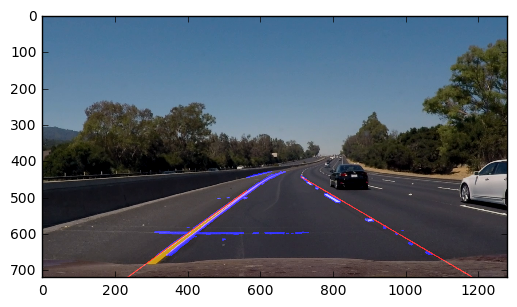

In [61]:
challenge_output = 'extra.mp4'
#clip2 = VideoFileClip('challenge.mp4').set_duration(3.7,change_end=True)
clip2 = VideoFileClip('challenge.mp4')
#clip2 = VideoFileClip('challenge.mp4').cutout(3.8,3.9)
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)